# ETL

In [1]:
import pandas as pd
import json
from bs4 import BeautifulSoup
import sqlite3
from sqlalchemy import create_engine
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import datetime

## 1. Extract
### 1.1 Read CSV Files
#### 1.1.1 `projects_data.csv`

In [2]:
df_projects = pd.read_csv('projects_data.csv', dtype=str)
df_projects.head()

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,Unnamed: 56
0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,NaN,Y,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG,NaN


In [3]:
# use the isnull() and sum() methods
df_projects.isnull().sum()

id                              0
regionname                      0
countryname                     0
prodline                        0
lendinginstr                  246
lendinginstrtype              246
envassesmentcategorycode     5811
supplementprojectflg           53
productlinetype                 0
projectstatusdisplay            4
status                          4
project_name                    0
boardapprovaldate            1504
board_approval_month         1504
closingdate                  3349
lendprojectcost               125
ibrdcommamt                     0
idacommamt                      0
totalamt                        0
grantamt                        0
borrower                     5919
impagency                    6097
url                             0
projectdoc                  18248
majorsector_percent         18248
sector1                         0
sector2                      8721
sector3                     11761
sector4                     13872
sector5       

Ta thấy số $18248$ xuất hiện nhiều lần. Data này có vấn đề cần đc xử lí ở transform part in pipeline.

In [4]:
# output the shape of the data frame
df_projects.shape

(18248, 57)

#### 1.1.2. `population_data.csv`

In [5]:
# read in population data skipping the first four rows
df_population = pd.read_csv('population_data.csv', skiprows=4)
df_population.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0,NaN


In [6]:
# Count the number of null values in each column
df_population.isnull().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960                4
                 ... 
2014                2
2015                2
2016                2
2017                2
Unnamed: 62       264
Length: 63, dtype: int64

Có vẻ mỗi year column đều có ít nhất một NaN value.

In [7]:
# Sum the null values by column
df_population.isnull().sum(axis=1)

0      1
1      1
2      1
3      1
4      1
      ..
259    1
260    1
261    1
262    1
263    1
Length: 264, dtype: int64

Có vẻ gần như mọi row đều chỉ có một null value, rất có thể là từ column `Unnamed: 62`. Tả bỏ đi column này.

In [8]:
df_population = df_population.drop('Unnamed: 62', axis=1)
# outputs any row that contains a null value
df_population[df_population.isnull().any(axis=1)]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
67,Eritrea,ERI,"Population, total",SP.POP.TOTL,1397491.0,1432640.0,1469645.0,1508273.0,1548187.0,1589179.0,...,4232636.0,4310334.0,4390840.0,4474690.0,NaN,NaN,NaN,NaN,NaN,NaN
108,Not classified,INX,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,Kuwait,KWT,"Population, total",SP.POP.TOTL,269618.0,301336.0,338296.0,379891.0,425235.0,473554.0,...,2652340.0,2818939.0,2998083.0,3191051.0,3395556.0,3598385.0,3782450.0,3935794.0,4052584.0,4136528.0
194,West Bank and Gaza,PSE,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,3596688.0,3702218.0,3811102.0,3927051.0,4046901.0,4169506.0,4294682.0,4422143.0,4551566.0,4684777.0
212,Serbia,SRB,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,7350222.0,7320807.0,7291436.0,7234099.0,7199077.0,7164132.0,7130576.0,7095383.0,7058322.0,7022268.0
223,Sint Maarten (Dutch part),SXM,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,33964.0,34238.0,34056.0,33435.0,34640.0,36607.0,37685.0,38824.0,39969.0,41109.0


### 1.2. JSON and XML
#### 1.2.1. JSON

In [9]:
# This cell loads a function that prints the first n lines of a file.
# Then this function is called on the JSON file to print out the first line of the population_data.json file
def print_lines(n, file_name):
    f = open(file_name)
    for i in range(n):
        print(f.readline())
    f.close()

print_lines(1, 'population_data.json')

[{"Country Name":"Aruba","Country Code":"ABW","Indicator Name":"Population, total","Indicator Code":"SP.POP.TOTL","1960":54211.0,"1961":55438.0,"1962":56225.0,"1963":56695.0,"1964":57032.0,"1965":57360.0,"1966":57715.0,"1967":58055.0,"1968":58386.0,"1969":58726.0,"1970":59063.0,"1971":59440.0,"1972":59840.0,"1973":60243.0,"1974":60528.0,"1975":60657.0,"1976":60586.0,"1977":60366.0,"1978":60103.0,"1979":59980.0,"1980":60096.0,"1981":60567.0,"1982":61345.0,"1983":62201.0,"1984":62836.0,"1985":63026.0,"1986":62644.0,"1987":61833.0,"1988":61079.0,"1989":61032.0,"1990":62149.0,"1991":64622.0,"1992":68235.0,"1993":72504.0,"1994":76700.0,"1995":80324.0,"1996":83200.0,"1997":85451.0,"1998":87277.0,"1999":89005.0,"2000":90853.0,"2001":92898.0,"2002":94992.0,"2003":97017.0,"2004":98737.0,"2005":100031.0,"2006":100832.0,"2007":101220.0,"2008":101353.0,"2009":101453.0,"2010":101669.0,"2011":102053.0,"2012":102577.0,"2013":103187.0,"2014":103795.0,"2015":104341.0,"2016":104822.0,"2017":105264.0},{"

In [10]:
# Read in the population_data.json file using pandas's read_json method.
# Don't forget to specific the orient option store the rsults in df_json
df_json = pd.read_json('population_data.json', orient='records')
df_json.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


Cũng có thể dùng `json` library để đọc JSON files. Python xử lí JSON data như dictionary.

In [11]:
# read in the JSON file
with open('population_data.json') as f:
    json_data = json.load(f)

# print the first record in the JSON file
print(json_data[0])
print('\n')

# show that JSON data is essentially a dictionary
print(json_data[0]['Country Name'])
print(json_data[0]['Country Code'])

{'Country Name': 'Aruba', 'Country Code': 'ABW', 'Indicator Name': 'Population, total', 'Indicator Code': 'SP.POP.TOTL', '1960': 54211.0, '1961': 55438.0, '1962': 56225.0, '1963': 56695.0, '1964': 57032.0, '1965': 57360.0, '1966': 57715.0, '1967': 58055.0, '1968': 58386.0, '1969': 58726.0, '1970': 59063.0, '1971': 59440.0, '1972': 59840.0, '1973': 60243.0, '1974': 60528.0, '1975': 60657.0, '1976': 60586.0, '1977': 60366.0, '1978': 60103.0, '1979': 59980.0, '1980': 60096.0, '1981': 60567.0, '1982': 61345.0, '1983': 62201.0, '1984': 62836.0, '1985': 63026.0, '1986': 62644.0, '1987': 61833.0, '1988': 61079.0, '1989': 61032.0, '1990': 62149.0, '1991': 64622.0, '1992': 68235.0, '1993': 72504.0, '1994': 76700.0, '1995': 80324.0, '1996': 83200.0, '1997': 85451.0, '1998': 87277.0, '1999': 89005.0, '2000': 90853.0, '2001': 92898.0, '2002': 94992.0, '2003': 97017.0, '2004': 98737.0, '2005': 100031.0, '2006': 100832.0, '2007': 101220.0, '2008': 101353.0, '2009': 101453.0, '2010': 101669.0, '2011'

#### 1.2.2. XML

In [12]:
print_lines(15, 'population_data.xml')

﻿<?xml version="1.0" encoding="utf-8"?>

<Root xmlns:wb="http://www.worldbank.org">

  <data>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1960</field>

      <field name="Value">54211</field>

    </record>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1961</field>

      <field name="Value">55438</field>

    </record>



In [13]:
# Get a basic idea of how to navigate XML with BeautifulSoup.
# To navigate through the xml file, you search for a specific tag using the find() method or find_all() method.
# open the population_data.xml file and load into Beautiful Soup
with open("population_data.xml") as fp:
    soup = BeautifulSoup(fp, "lxml") # lxml is the Parser type

In [14]:
# output the first 5 records in the xml file
# this is an example of how to navigate with BeautifulSoup

i = 0
# use the find_all method to get all record tags in the document
for record in soup.find_all('record'):
    # use the find_all method to get all fields in each record
    i += 1
    for record in record.find_all('field'):
        print(record['name'], ': ' , record.text)
    print()
    if i == 5:
        break

Country or Area :  Aruba
Item :  Population, total
Year :  1960
Value :  54211

Country or Area :  Aruba
Item :  Population, total
Year :  1961
Value :  55438

Country or Area :  Aruba
Item :  Population, total
Year :  1962
Value :  56225

Country or Area :  Aruba
Item :  Population, total
Year :  1963
Value :  56695

Country or Area :  Aruba
Item :  Population, total
Year :  1964
Value :  57032



#### 1.2.3. XML Exercise

In [15]:
# TODO: Create a pandas data frame from the XML data.
# HINT: You can use dictionaries to create pandas data frames.
# HINT: You can make a dictionary for each column or for each row
# HINT: Modify the code from the previous code cell

# output the first 5 records in the xml file
# this is an example of how to navigate with BeautifulSoup

# use the find_all method to get all record tags in the document
data_dictionary = {'Country or Area':[], 'Year':[], 'Item':[], 'Value':[]}

for record in soup.find_all('record'):
    for record in record.find_all('field'):
        data_dictionary[record['name']].append(record.text)

df = pd.DataFrame.from_dict(data_dictionary)
df = df.pivot(index='Country or Area', columns='Year', values='Value')
df.reset_index(level=0, inplace=True)
df

Year,Country or Area,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,8996351,9166764,9345868,9533954,9731361,9938414,10152331,10372630,10604346,...,27294031,28004331,28803167,29708599,30696958,31731688,32758020,33736494,34656032,35530081
1,Albania,1608800,1659800,1711319,1762621,1814135,1864791,1914573,1965598,2022272,...,2947314,2927519,2913021,2905195,2900401,2895092,2889104,2880703,2876101,2873457
2,Algeria,11124888,11404859,11690153,11985136,12295970,12626952,12980267,13354197,13744387,...,34860715,35465760,36117637,36819558,37565847,38338562,39113313,39871528,40606052,41318142
3,American Samoa,20013,20486,21117,21882,22698,23520,24321,25116,25885,...,57030,56227,55637,55320,55230,55307,55437,55537,55599,55641
4,Andorra,13411,14375,15370,16412,17469,18549,19647,20758,21890,...,83861,84462,84449,83751,82431,80788,79223,78014,77281,76965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,West Bank and Gaza,,,,,,,,,,...,3596688,3702218,3811102,3927051,4046901,4169506,4294682,4422143,4551566,4684777
260,World,3032160395,3073368589,3126509809,3191786428,3257459749,3324545319,3394783653,3464689185,3535355316,...,6766296679,6849569339,6932869743,7014983968,7099557649,7185137526,7271322821,7357559450,7444157356,7530360149
261,"Yemen, Rep.",5172135,5260501,5351799,5446063,5543339,5643643,5748588,5858638,5971407,...,22356391,22974929,23606779,24252206,24909969,25576322,26246327,26916207,27584213,28250420
262,Zambia,3044846,3140264,3240587,3345145,3452942,3563407,3676189,3791887,3912085,...,13082517,13456417,13850033,14264756,14699937,15153210,15620974,16100587,16591390,17094130


### 1.3. SQL
#### 1.3.1. SQLite
Có một SQLite DB file là `population_data.db`. SQLite là một DB engine cho single applications. Entire DB is contained in one file.

In [16]:
# connect to the database
conn = sqlite3.connect('population_data.db')
# run a query
pd.read_sql('SELECT * FROM population_data', conn)

,index,Country_Name,Country_Code,Indicator_Name,Indicator_Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [17]:
pd.read_sql('SELECT "Country_Name", "Country_Code", "1960" FROM population_data', conn)

,Country_Name,Country_Code,1960
0,Aruba,ABW,54211.0
1,Afghanistan,AFG,8996351.0
2,Angola,AGO,5643182.0
3,Albania,ALB,1608800.0
4,Andorra,AND,13411.0
...,...,...,...
259,Kosovo,XKX,947000.0
260,"Yemen, Rep.",YEM,5172135.0
261,South Africa,ZAF,17456855.0
262,Zambia,ZMB,3044846.0


#### 1.3.2. SQLAlchemy
Nếu có DB type khác như MySQL hay PostgreSQL, ta có thể dùng `SQLAlchemy` library with `pandas`.

In [18]:
# create a database engine
engine = create_engine(f'sqlite:///{os.getcwd()}/population_data.db')
pd.read_sql("SELECT * FROM population_data", engine)

,index,Country_Name,Country_Code,Indicator_Name,Indicator_Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


#### 1.3.3. SQL Exercise
1. Write a query that finds the change in population from 1960 to 1961 in Aruba
2. Write a query that finds the population of Belgium and also Luxembourg in 1975. The output should have two rows.

In [19]:
pd.read_sql('SELECT "1961" - "1960" FROM population_data WHERE Country_Name = "Aruba"', engine)

,"""1961"" - ""1960"""
0,1227.0


In [20]:
pd.read_sql('SELECT "Country_Name", "1975" FROM population_data WHERE Country_Name = "Belgium" OR Country_Name = "Luxembourg"', engine)

,Country_Name,1975
0,Belgium,9800700.0
1,Luxembourg,358950.0


### 1.4. APIs
#### 1.4.1. Example
Run the code example below to request data from the World Bank Indicators API. According to the documntation, you format your request url like so:

`http://api.worldbank.org/v2/countries/` + list of country abbreviations separated by ; + `/indicators/` + indicator name + `?` + options

where options can include
* per_page - number of records to return per page
* page - which page to return - eg if there are 5000 records and 100 records per page
* date - filter by dates
* format - json or xml

 and a few other options that you can read about [here](https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structure).

In [21]:
url = 'http://api.worldbank.org/v2/countries/br;cn;us;de/indicators/SP.POP.TOTL/?format=json&per_page=1000'
r = requests.get(url)
r.json()

[{'page': 1,
  'pages': 1,
  'per_page': 1000,
  'total': 260,
  'sourceid': '2',
  'lastupdated': '2025-06-05'},
 [{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2024',
   'value': None,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2023',
   'value': 211140729,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2022',
   'value': 210306415,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2021',
   '

First entry is meta data about the results, ở đây là one page returned with 260 results. Second entry is another list containing the data. This data would need some cleaning to be used in a pandas data frame.

In [22]:
# Convert the json into a dataframe
pd.DataFrame(r.json()[1])

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2024,NaN,,,0
1,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2023,211140729.0,,,0
2,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2022,210306415.0,,,0
3,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2021,209550294.0,,,0
4,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2020,208660842.0,,,0
...,...,...,...,...,...,...,...,...
255,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'US', 'value': 'United States'}",USA,1964,191889000.0,,,0
256,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'US', 'value': 'United States'}",USA,1963,189242000.0,,,0
257,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'US', 'value': 'United States'}",USA,1962,186538000.0,,,0
258,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'US', 'value': 'United States'}",USA,1961,183691000.0,,,0


#### 1.4.2 Exercise
Use the Indicators API rural population data for Switzerland in the years 1995 through 2001. Here are a few helpful resources:
* [documentation included how to filter by year](https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structure)
* [2-character iso country codes](https://www.nationsonline.org/oneworld/country_code_list.htm)
* [search box for World Bank indicators](https://data.worldbank.org)

To find the indicator code, first search for the indicator here: https://data.worldbank.org
Click on the indicator name. The indicator code is in the url. For example, the indicator code for total population is SP.POP.TOTL. The link is [https://data.worldbank.org/indicator/SP.RUR.TOTL](https://data.worldbank.org/indicator/SP.RUR.TOTL).

In [23]:
url = 'http://api.worldbank.org/v2/countries/ch/indicators/SP.RUR.TOTL/?format=json&date=1995:2001'
r = requests.get(url)
r.json()

[{'page': 1,
  'pages': 1,
  'per_page': 50,
  'total': 7,
  'sourceid': '2',
  'lastupdated': '2025-06-05'},
 [{'indicator': {'id': 'SP.RUR.TOTL', 'value': 'Rural population'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '2001',
   'value': 1924949,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.RUR.TOTL', 'value': 'Rural population'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '2000',
   'value': 1912232,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.RUR.TOTL', 'value': 'Rural population'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '1999',
   'value': 1897587,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.RUR.TOTL', 'value': 'Rural population'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '

## 2. Transform
### 2.1. Combining Data
#### 2.1.1 Exercise 1
Combine the two data sets using the pandas `concat` method.

In [24]:
# read in each csv file into a separate variable
df_rural = pd.read_csv('rural_population_percent.csv', skiprows=4)
df_electricity = pd.read_csv('electricity_access_percent.csv', skiprows=4)

# remove the 'Unnamed: 62' column from each data set
df_rural.drop('Unnamed: 62', axis=1, inplace=True)
df_electricity.drop('Unnamed: 62', axis=1, inplace=True)

# combine the two data sets together using the concat method.
# This is possible to do because they both have the same column names.
df = pd.concat([df_rural, df_electricity])
df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,...,56.217000,56.579000,56.941000,57.302000,57.636000,57.942000,58.221000,58.472000,58.696000,58.893
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,...,76.054000,75.687000,75.311000,74.926000,74.532000,74.129000,73.718000,73.297000,72.868000,72.430
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,...,61.491000,60.701000,59.903000,59.100000,58.301000,57.510000,56.726000,55.950000,55.181000,54.422
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,...,50.009000,48.924000,47.837000,46.753000,45.670000,44.617000,43.591000,42.593000,41.624000,40.684
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,...,11.133000,11.648000,12.183000,12.740000,13.292000,13.835000,14.367000,14.885000,15.388000,15.873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,97.794670,98.377060,0.000000,99.430435,99.773651,99.942505,99.993134,100.000000,100.000000,NaN
260,"Yemen, Rep.",YEM,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,60.386539,61.751400,63.134281,64.532181,65.942101,75.600000,66.100000,70.213905,71.642349,NaN
261,South Africa,ZAF,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.900000,82.700000,82.900000,84.700000,85.300000,85.400000,86.000000,85.500000,84.200000,NaN
262,Zambia,ZMB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,22.714685,23.235649,22.000000,24.328644,24.894667,25.469702,27.900000,31.100000,27.219337,NaN


#### 2.1.2 Excersice 2
Combine data thành df có các columns: Country, Name, Country Code, Year, Rural_Value, Electricity_Value

In [25]:
# merge the data sets together according to the instructions.
# First, use the melt method to change the formatting of each data frame so that it looks like this:
# Country Name, Country Code, Year, Rural Value
# Country Name, Country Code, Year, Electricity Value
df_rural_melt = pd.melt(df_rural,\
                        id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],\
                       var_name = 'Year', value_name='Rural_Value')
df_electricity_melt = pd.melt(df_electricity,\
                              id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],\
                             var_name='Year', value_name='Electricity_Value')

# drop any columns from the data frames that aren't needed
df_rural_melt.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_electricity_melt.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)

# merge the data frames together based on their common columns
# in this case, the common columns are Country Name, Country Code, and Year
df_merge = df_rural_melt.merge(df_electricity_melt, how='outer',\
                               on=['Country Name', 'Country Code', 'Year'])

# sort the results by country and then by year
df_combined = df_merge.sort_values(['Country Name', 'Year'])
df_combined

,Country Name,Country Code,Year,Rural_Value,Electricity_Value
1,Afghanistan,AFG,1960,91.779,NaN
265,Afghanistan,AFG,1961,91.492,NaN
529,Afghanistan,AFG,1962,91.195,NaN
793,Afghanistan,AFG,1963,90.890,NaN
1057,Afghanistan,AFG,1964,90.574,NaN
...,...,...,...,...,...
14255,Zimbabwe,ZWE,2013,67.346,37.076813
14519,Zimbabwe,ZWE,2014,67.499,32.300000
14783,Zimbabwe,ZWE,2015,67.624,33.700000
15047,Zimbabwe,ZWE,2016,67.723,38.145138


### 2.2. Cleaning Data
#### 2.2.1 Format country code

In [26]:
# read in the population data and drop the final column
df_indicator = pd.read_csv('population_data.csv', skiprows=4)
df_indicator.drop(['Unnamed: 62'], axis=1, inplace=True)

# read in the projects data set with all columns type string
df_projects = pd.read_csv('projects_data.csv', dtype=str)
df_projects.drop(['Unnamed: 56'], axis=1, inplace=True)

In [27]:
# Outputs the unique country names and ISO abbreviations in the population indicator data set
df_indicator[['Country Name', 'Country Code']].drop_duplicates()

,Country Name,Country Code
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO
3,Albania,ALB
4,Andorra,AND
...,...,...
259,Kosovo,XKX
260,"Yemen, Rep.",YEM
261,South Africa,ZAF
262,Zambia,ZMB


Run the next code cell to see the unique country names in the project data set. Notice that the projects data has two columns for country name. One is called 'countryname' and the other is called 'Country'. The 'Country' column only has NaN values.

Another thing of note: It would've been easier to join the two data sets together if the projects data had the ISO country abbreviations like the indicator data has. Unfortunately, the projects data does not have the ISO country abbreviations. To join these two data sets together, you essentially have two choices:
- add a column of ISO 3 codes to the projects data set
- find the difference between the projects data country names and indicator data country names. Then clean the data so that they are the same.

In [28]:
df_projects['countryname'].unique()

array(['World;World',
       'Democratic Republic of the Congo;Democratic Republic of the Congo',
       "People's Republic of Bangladesh;People's Republic of Bangladesh",
       'Islamic  Republic of Afghanistan;Islamic  Republic of Afghanistan',
       'Federal Republic of Nigeria;Federal Republic of Nigeria',
       'Republic of Tunisia;Republic of Tunisia',
       'Lebanese Republic;Lebanese Republic',
       'Democratic Socialist Republic of Sri Lan;Democratic Socialist Republic of Sri Lan',
       'Nepal;Nepal', 'Kyrgyz Republic;Kyrgyz Republic',
       'Hashemite Kingdom of Jordan;Hashemite Kingdom of Jordan',
       'Republic of the Union of Myanmar;Republic of the Union of Myanmar',
       'Arab Republic of Egypt;Arab Republic of Egypt',
       'United Republic of Tanzania;United Republic of Tanzania',
       'Federal Democratic Republic of Ethiopia;Federal Democratic Republic of Ethiopia',
       'Burkina Faso;Burkina Faso',
       'Republic of Uzbekistan;Republic of Uzbekist

The entries are repeated and separated by a semi-colon like this: 'Kingdom of Spain;Kingdom of Spain'; 'New Zealand;New Zealand'

Clean the country name column and get rid of the semi-colon.

In [29]:
# Ceate a new column called 'Official Country Name' so that the country name only appears once.
# For example, `Republic of Malta;Republic of Malta` should be `Republic of Malta`.
df_projects['Official Country Name'] = df_projects['countryname'].str.split(';').str.get(0)

It looks like the projects data set has official country names. Hence, this data set has an entry like "Kingdom of Spain" whereas the indicators data has just "Spain".

Luckily, someone has developed a Python library called pycountry. This library has country names, ISO abbreviations, and official country names.

In [30]:
from pycountry import countries
countries.get(name='Spain')

Country(alpha_2='ES', alpha_3='ESP', flag='🇪🇸', name='Spain', numeric='724', official_name='Kingdom of Spain')

In [31]:
countries.lookup('Kingdom of Spain')

Country(alpha_2='ES', alpha_3='ESP', flag='🇪🇸', name='Spain', numeric='724', official_name='Kingdom of Spain')

The goal is to add the ISO codes to the projects data set. To start, use the pycountry library to make a dictionary mapping the unique countries in 'Official Country Name' to the ISO code.

Iterate through the unique countries in df_projects['Official Country Name']. Create a dictionary mapping the 'Country Name' to the alpha_3 ISO abbreviations.

The dictionary should look like: {'Kingdom of Spain':'ESP'}

If a country name cannot be found in the pycountry library, add it to a list called country_not_found.

In [32]:
# set up the libraries and variables
from collections import defaultdict
country_not_found = [] # stores countries not found in the pycountry library
project_country_abbrev_dict = defaultdict(str) # set up an empty dictionary of string values

# iterate through the country names in df_projects.
# Create a dictionary mapping the country name to the alpha_3 ISO code
for country in df_projects['Official Country Name'].drop_duplicates().sort_values():
    try:
        # look up the country name in the pycountry library
        # store the country name as the dictionary key and the ISO-3 code as the value
        project_country_abbrev_dict[country] = countries.lookup(country).alpha_3
    except:
        # If the country name is not in the pycountry library, then print out the country name
        # And store the results in the country_not_found list
        print(country, ' not found')
        country_not_found.append(country)

Africa  not found
Andean Countries  not found
Aral Sea  not found
Asia  not found
Caribbean  not found
Caucasus  not found
Central Africa  not found
Central America  not found
Central Asia  not found
Co-operative Republic of Guyana  not found
Commonwealth of Australia  not found
Democratic Republic of Sao Tome and Prin  not found
Democratic Republic of the Congo  not found
Democratic Socialist Republic of Sri Lan  not found
EU Accession Countries  not found
East Asia and Pacific  not found
Eastern Africa  not found
Europe and Central Asia  not found
Islamic  Republic of Afghanistan  not found
Kingdom of Swaziland  not found
Latin America  not found
Macedonia  not found
Mekong  not found
Mercosur  not found
Middle East and North Africa  not found
Multi-Regional  not found
Organization of Eastern Caribbean States  not found
Oriental Republic of Uruguay  not found
Pacific Islands  not found
Red Sea and Gulf of Aden  not found
Republic of Congo  not found
Republic of Cote d'Ivoire  not fou

Perhaps some of these missing df_projects countries are already in the indicators data set. In the next cell, check if any of the countries in the country_not_found list are in the indicator list of countries.

In [33]:
# Run this cell to iterate through the country_not_found list and check if the country name is in the df_indicator data set
indicator_countries = df_indicator[['Country Name', 'Country Code']].drop_duplicates().sort_values(by='Country Name')

for country in country_not_found:
    if country in indicator_countries['Country Name'].tolist():
        print(country)

South Asia
St. Kitts and Nevis
St. Lucia
St. Vincent and the Grenadines
West Bank and Gaza
World


Unfortunately, there aren't too many country names that match between df_indicator and df_projects.

We've manually created a dictionary that maps all of the countries in country_not_found to the ISO-3 alpha codes.

In [34]:
country_not_found_mapping = {'Co-operative Republic of Guyana': 'GUY',
             'Commonwealth of Australia':'AUS',
             'Democratic Republic of Sao Tome and Prin':'STP',
             'Democratic Republic of the Congo':'COD',
             'Democratic Socialist Republic of Sri Lan':'LKA',
             'East Asia and Pacific':'EAS',
             'Europe and Central Asia': 'ECS',
             'Islamic  Republic of Afghanistan':'AFG',
             'Latin America':'LCN',
              'Caribbean':'LCN',
             'Macedonia':'MKD',
             'Middle East and North Africa':'MEA',
             'Oriental Republic of Uruguay':'URY',
             'Republic of Congo':'COG',
             "Republic of Cote d'Ivoire":'CIV',
             'Republic of Korea':'KOR',
             'Republic of Niger':'NER',
             'Republic of Kosovo':'XKX',
             'Republic of Rwanda':'RWA',
              'Republic of The Gambia':'GMB',
              'Republic of Togo':'TGO',
              'Republic of the Union of Myanmar':'MMR',
              'Republica Bolivariana de Venezuela':'VEN',
              'Sint Maarten':'SXM',
              "Socialist People's Libyan Arab Jamahiriy":'LBY',
              'Socialist Republic of Vietnam':'VNM',
              'Somali Democratic Republic':'SOM',
              'South Asia':'SAS',
              'St. Kitts and Nevis':'KNA',
              'St. Lucia':'LCA',
              'St. Vincent and the Grenadines':'VCT',
              'State of Eritrea':'ERI',
              'The Independent State of Papua New Guine':'PNG',
              'West Bank and Gaza':'PSE',
              'World':'WLD'}

# Update the project_country_abbrev_dict with the country_not_found_mapping dictionary
project_country_abbrev_dict.update(country_not_found_mapping)

In [35]:
# Use the project_country_abbrev_dict and the df_projects['Country Name'] column to make a new column
# of the alpha-3 country codes. This new column should be called 'Country Code'.
df_projects['Country Code'] = df_projects['Official Country Name'].apply(lambda x: project_country_abbrev_dict[x])

# Run this code cell to see which projects in the df_projects data frame still have no country code abbreviation.
# In other words, these projects do not have a matching population value in the df_indicator data frame.
df_projects[df_projects['Country Code'] == '']

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,Official Country Name,Country Code
31,P166648,Africa,Central Africa;Central Africa,RE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Central Africa,
39,P163752,Africa,Africa;Africa,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa,
58,P164728,Africa,Africa;Africa,PE,Investment Project Financing,IN,NaN,Y,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa,
69,P161329,Africa,Western Africa;Western Africa,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Western Africa,
103,P164468,East Asia and Pacific,Pacific Islands;Pacific Islands,PE,Investment Project Financing,IN,NaN,Y,L,Active,...,NaN,NaN,0002134431!$!Republic of Vanuatu!$!-16!$!167!$...,0002134431;0002135171,Republic of Vanuatu;Port-Vila,-16;-17.73381,167;168.32188,VU;VU,Pacific Islands,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18197,P009134,Europe and Central Asia,Socialist Federal Republic of Yugoslavia;Socia...,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Socialist Federal Republic of Yugoslavia,
18215,P008873,Europe and Central Asia,Republic of Turkey;Republic of Turkey,PE,Financial Intermediary Loan,IN,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republic of Turkey,
18221,P008872,Europe and Central Asia,Republic of Turkey;Republic of Turkey,PE,Specific Investment Loan,IN,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republic of Turkey,
18222,P008874,Europe and Central Asia,Republic of Turkey;Republic of Turkey,PE,Specific Investment Loan,IN,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republic of Turkey,


#### 2.2.2 Data type

In [36]:
df_indicator.dtypes

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

These results look reasonable. Country Name, Country Code, Indicator Name and Indicator Code were all read in as strings. The year columns, which contain the population data, were read in as floats. Since the population indicator data was read in correctly, you can run calculations on the data.

In [37]:
# Calculate the population sum by year for Canada, the United States, and Mexico.
keepcol = ['Country Name']
for i in range(1960, 2018, 1):
    keepcol.append(str(i))

df_nafta = df_indicator[(df_indicator['Country Name'] == 'Canada') |
             (df_indicator['Country Name'] == 'United States') |
            (df_indicator['Country Name'] == 'Mexico')].iloc[:,]

df_nafta.sum(axis=0)[keepcol]

Country Name    CanadaMexicoUnited States
1960                          236754121.0
1961                          241356126.0
1962                          245801588.0
1963                          250145880.0
1964                          254478272.0
1965                          258604043.0
1966                          262619038.0
1967                          266553812.0
1968                          270344019.0
1969                          274128481.0
1970                          278405861.0
1971                          283025259.0
1972                          287367782.0
1973                          291558995.0
1974                          295716280.0
1975                          300054399.0
1976                          304176763.0
1977                          308380884.0
1978                          312660488.0
1979                          317041689.0
1980                          321178871.0
1981                          325358195.0
1982                          3294

In [38]:
df_projects.dtypes

id                          object
regionname                  object
countryname                 object
prodline                    object
lendinginstr                object
lendinginstrtype            object
envassesmentcategorycode    object
supplementprojectflg        object
productlinetype             object
projectstatusdisplay        object
status                      object
project_name                object
boardapprovaldate           object
board_approval_month        object
closingdate                 object
lendprojectcost             object
ibrdcommamt                 object
idacommamt                  object
totalamt                    object
grantamt                    object
borrower                    object
impagency                   object
url                         object
projectdoc                  object
majorsector_percent         object
sector1                     object
sector2                     object
sector3                     object
sector4             

In [39]:
df_projects[['totalamt', 'lendprojectcost']].head()

,totalamt,lendprojectcost
0,0,"500,000"
1,"200,000,000","200,000,000"
2,"58,330,000","50,000,000"
3,"20,000,000","50,000,000"
4,"100,000,000","100,000,000"


In [40]:
# Run this code cell to take the sum of the total amount column
df_projects['totalamt'].sum()

'0200,000,00058,330,00020,000,000100,000,000500,000,000350,000,000225,000,000125,000,000329,900,000200,000,000400,000,0000150,000,0000389,000,0000530,000,000350,000,000202,000,000300,000,000500,000,000493,060,000175,000,0000230,000,00080,000,000400,000,000130,000,00030,000,00035,000,0000250,000,000200,000,000400,000,000110,000,000150,000,00074,000,000118,000,000465,000,000050,000,00090,000,000100,000,000130,000,00010,000,000460,600,000100,000,000700,000,00030,000,000280,000,00040,000,000300,000,00090,000,000150,000,000150,000,00043,000,000100,000,00015,000,00015,000,000012,000,00030,000,000100,000,000250,000,000200,000,000150,000,00025,000,000500,000,000122,100,00020,000,00007,390,000000050,000,00075,000,00060,000,00025,000,00015,000,00000300,000,00025,000,00011,000,0009,000,000130,000,000140,000,000100,000,000200,000,00070,000,000140,000,00020,000,000188,000,000200,000,000500,000,00014,200,00040,000,000150,000,000003,550,000600,000,000400,000,0000150,000,0006,000,00012,000,000100,000,

Pandas treated the totalamts like strings. In Python, adding strings concatenates the strings together.

There are a few ways to remedy this. When using pd.read_csv(), you could specify the column type for every column in the data set. The pd.read_csv() dtype option can accept a dictionary mapping each column name to its data type. You could also specify the thousands option with thousands=','. This specifies that thousands are separated by a comma in this data set.

However, this data is somewhat messy, contains missing values, and has a lot of columns. It might be faster to read in the entire data set with string types and then convert individual columns as needed. For this next exercise, convert the totalamt column from a string to an integer type.

In [41]:
# Convert the totalamt column from a string to a float and save the results back into the totalamt column
df_projects['totalamt'] = pd.to_numeric(df_projects['totalamt'].str.replace(',',""))

#### 2.2.3 Parsing dates

In [42]:
parsed_date = pd.to_datetime('January 1st, 2017')
parsed_date

Timestamp('2017-01-01 00:00:00')

In [43]:
print(parsed_date.year, parsed_date.month, parsed_date.second)

2017 1 0


In [44]:
parsed_date = pd.to_datetime('3/5/2017 5:30', format='%d/%m/%Y %H:%M')
parsed_date.month

5

In [45]:
parsed_date = pd.to_datetime('5/3/2017 5:30', format='%m/%d/%Y %H:%M')
parsed_date.month

5

In [46]:
# read in the projects data set with all columns type string
df_projects = pd.read_csv('projects_data.csv', dtype=str)
df_projects.drop(['Unnamed: 56'], axis=1, inplace=True)
df_projects.columns

Index(['id', 'regionname', 'countryname', 'prodline', 'lendinginstr',
       'lendinginstrtype', 'envassesmentcategorycode', 'supplementprojectflg',
       'productlinetype', 'projectstatusdisplay', 'status', 'project_name',
       'boardapprovaldate', 'board_approval_month', 'closingdate',
       'lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt',
       'borrower', 'impagency', 'url', 'projectdoc ', 'majorsector_percent ',
       'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'sector',
       'mjsector1', 'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5',
       'mjsector', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5', 'theme ',
       'goal', 'financier', 'mjtheme1name', 'mjtheme2name', 'mjtheme3name',
       'mjtheme4name', 'mjtheme5name', 'location', 'GeoLocID', 'GeoLocName',
       'Latitude', 'Longitude', 'Country'],
      dtype='object')

In [47]:
df_projects.head(15)[['boardapprovaldate', 'board_approval_month', 'closingdate']]

,boardapprovaldate,board_approval_month,closingdate
0,2018-06-28T00:00:00Z,June,NaN
1,2018-06-28T00:00:00Z,June,2023-12-31T00:00:00Z
2,2018-06-28T00:00:00Z,June,NaN
3,2018-06-27T00:00:00Z,June,2023-06-28T00:00:00Z
4,2018-06-27T00:00:00Z,June,2023-05-31T00:00:00Z
5,2018-06-27T00:00:00Z,June,2019-12-31T00:00:00Z
6,2018-06-27T00:00:00Z,June,2023-10-31T00:00:00Z
7,2018-06-27T00:00:00Z,June,2023-12-31T00:00:00Z
8,2018-06-27T00:00:00Z,June,2022-12-31T00:00:00Z
9,2018-06-27T00:00:00Z,June,2023-12-31T00:00:00Z


In [48]:
#  Use the pandas to_datetime method to convert these two columns (boardapprovaldate, closingdate) into date times.
df_projects['boardapprovaldate'] = pd.to_datetime(df_projects['boardapprovaldate'])
df_projects['closingdate'] = pd.to_datetime(df_projects['closingdate'])

In [49]:
# Run the code cells below to see how you can access the different parts of the datetime objects
df_projects['boardapprovaldate'].dt.second

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
18243    0.0
18244    0.0
18245    0.0
18246    0.0
18247    0.0
Name: boardapprovaldate, Length: 18248, dtype: float64

In [50]:
df_projects['boardapprovaldate'].dt.month

0        6.0
1        6.0
2        6.0
3        6.0
4        6.0
        ... 
18243    3.0
18244    8.0
18245    8.0
18246    8.0
18247    5.0
Name: boardapprovaldate, Length: 18248, dtype: float64

In [51]:
# weekday represents the day of the week from 0 (Monday) to 6 (Sunday).
df_projects['boardapprovaldate'].dt.weekday

0        3.0
1        3.0
2        3.0
3        2.0
4        2.0
        ... 
18243    3.0
18244    3.0
18245    4.0
18246    3.0
18247    4.0
Name: boardapprovaldate, Length: 18248, dtype: float64

In [52]:
# create the follwing new columns in the df_projects data frame
# approvalyear
# approvalday
# approvalweekday
# closingyear
# closingday
# closingweekday
df_projects['approvalyear'] = df_projects['boardapprovaldate'].dt.year
df_projects['approvalday'] = df_projects['boardapprovaldate'].dt.day
df_projects['approvalweekday'] = df_projects['boardapprovaldate'].dt.weekday
df_projects['closingyear'] = df_projects['closingdate'].dt.year
df_projects['closingday'] = df_projects['closingdate'].dt.day
df_projects['closingweekday'] = df_projects['closingdate'].dt.weekday

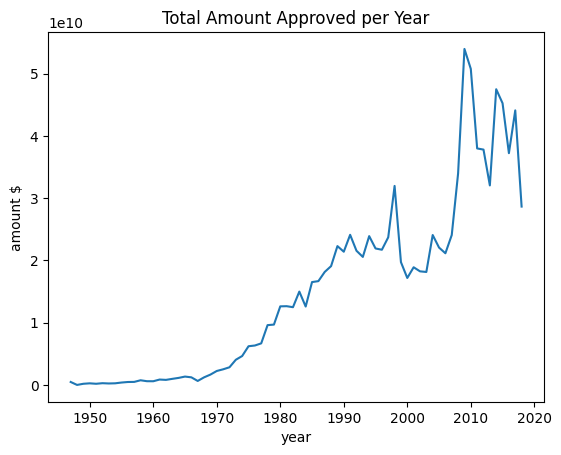

In [53]:
# Make a visualization with year on the x-axis and the sum of the totalamt columns per year on the y-axis
# The totalamt column is currently a string with commas. For example 100,250,364. You'll need to remove the
#         commas and convert the column to a numeric variable.

df_projects['totalamt'] = pd.to_numeric(df_projects['totalamt'].str.replace(',',''))
ax = df_projects.groupby('approvalyear')['totalamt'].sum().plot(x='approvalyear', y='totalamt',
                                                          title ='Total Amount Approved per Year')
ax.set_xlabel('year')
ax.set_ylabel('amount $')
plt.show()

#### 2.2.4 Matching Encodings

In [54]:
# Có error UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte.
# This means pandas assumed the file had a utf-8 encoding but had trouble reading in the data file.
# df = pd.read_csv('mystery.csv')

In [55]:
# Figure out what the encoding is of the myster.csv file
# HINT: pd.read_csv('mystery.csv', encoding=?) where ? is the string for an encoding like 'ascii'

# Python has a file containing a dictionary of encoding names and associated aliases
# This line imports the dictionary and then creates a set of all available encodings
# You can use this set of encodings to search for the correct encoding

from encodings.aliases import aliases
alias_values = set(aliases.values())

# iterate through the alias_values list trying out the different encodings to see which one or ones work
for encoding in set(aliases.values()):
    try:
        df=pd.read_csv("mystery.csv", encoding=encoding)
        print('successful', encoding)
    except:
        pass

successful utf_16_be
successful utf_16
successful cp273
successful cp037
successful cp1026
successful cp500
successful utf_16_le
successful cp1140


There is a Python library that can be of some help when you don't know an encoding: chardet. Run the code cells below to see how it works.

In [56]:
import chardet

# use the detect method to find the encoding
with open("mystery.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


#### 2.2.5 Missing data

In [57]:
df = pd.read_csv('gdp_data.csv', skiprows=4)
df.drop('Unnamed: 62', axis=1, inplace=True)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.417804e+10,7.549239e+10,8.252614e+10,1.041158e+11,1.139232e+11,1.249125e+11,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09


In [58]:
# Check how many null values are in the data set
df.isnull().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
                 ... 
2013               16
2014               17
2015               18
2016               23
2017               30
Length: 62, dtype: int64

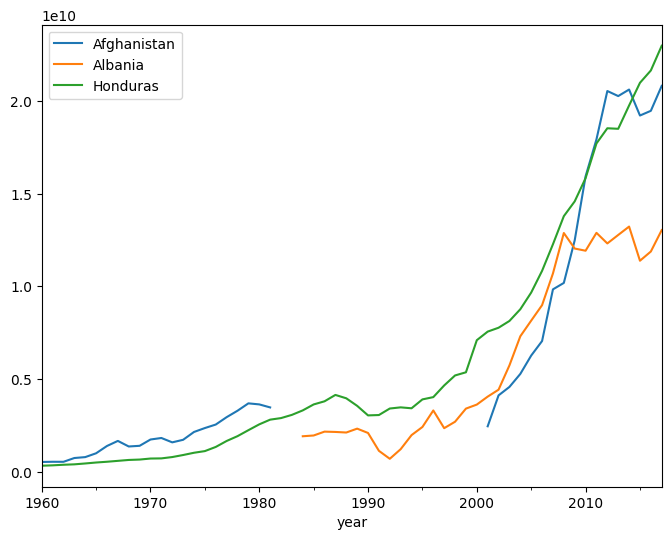

In [59]:
# plot the data for a few countries in the data set.
# put the data set into long form instead of wide
df_melt = pd.melt(df, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='year', value_name='GDP')

# convert year to a date time
df_melt['year'] = pd.to_datetime(df_melt['year'])

def plot_results(column_name):
    # plot the results for Afghanistan, Albania, and Honduras
    fig, ax = plt.subplots(figsize=(8,6))

    df_melt[(df_melt['Country Name'] == 'Afghanistan') |
            (df_melt['Country Name'] == 'Albania') |
            (df_melt['Country Name'] == 'Honduras')].groupby('Country Name').plot('year', column_name, legend=True, ax=ax)
    ax.legend(labels=['Afghanistan', 'Albania', 'Honduras'])

plot_results('GDP')

Afghanistan and Albania are missing data, which show up as gaps in the results.

Your first task is to calculate mean GDP for each country and fill in missing values with the country mean.

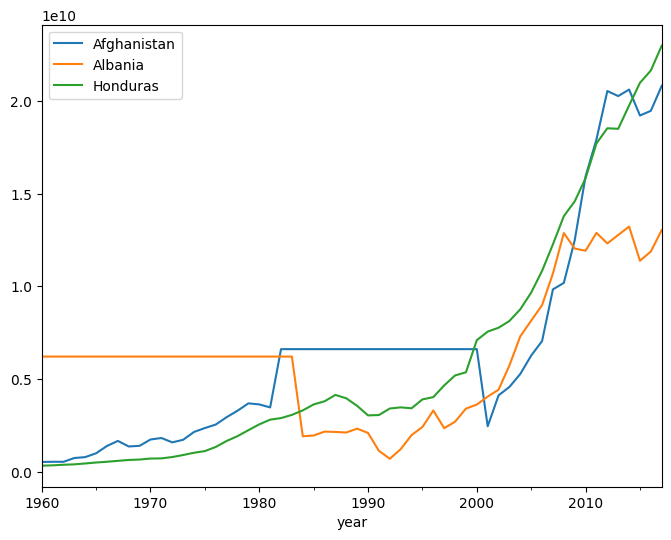

In [60]:
# Use the df_melt dataframe and fill in missing values with a country's mean GDP
# Put the results in a new column called 'GDP_filled'.
# HINT: You can do this with these methods: groupby(), transform(), a lambda function, fillna(), and mean()

df_melt['GDP_filled'] = df_melt.groupby('Country Name')['GDP'].transform(lambda x: x.fillna(x.mean()))
plot_results('GDP_filled')

 Next, try using forward fill to deal with any missing values. For example, if you wanted to use forward fill on the GDP dataset, you could execute df_melt['GDP'].fillna(method='ffill'). However, there are two issues with that code.
- You want to first make sure the data is sorted by year
- You need to group the data by country name so that the forward fill stays within each country

Write code to first sort the df_melt dataframe by year, then group by 'Country Name', and finally use the forward fill method.

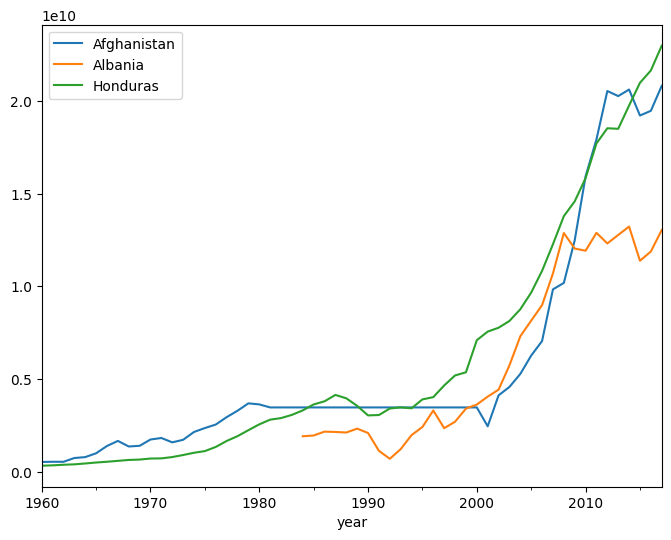

In [61]:
# Use forward fill to fill in missing GDP values
# HINTS: use the sort_values(), groupby(), and fillna() methods
df_melt['GDP_ffill'] = df_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='ffill')
plot_results('GDP_ffill')

This looks better at least for the Afghanistan data; however, the Albania data is still missing values. You can fill in the Albania data using back fill.

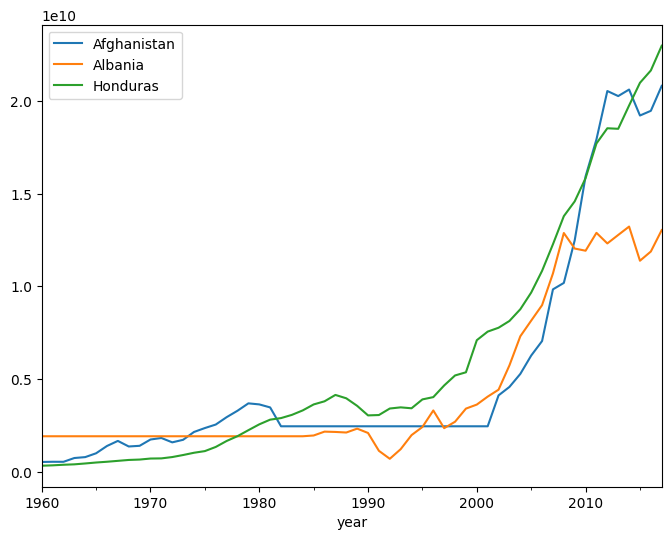

In [62]:
# Use back fill to fill in missing GDP values
# HINTS: use the sort_values(), groupby(), and fillna() methods
df_melt['GDP_bfill'] = df_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='bfill')
plot_results('GDP_bfill')

To completely fill the entire GDP data for all countries, you might have to run both forward fill and back fill. Note as well that the results will be slightly different depending on if you run forward fill first or back fill first. Afghanistan, for example, is missing data in the middle of the data set. Hence forward fill and back fill will have slightly different results.

In [63]:
# Run forward fill and backward fill on the GDP data
df_melt['GDP_ff_bf'] = df_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='ffill').fillna(method='bfill')

# Check if any GDP values are null
df_melt['GDP_ff_bf'].isnull().sum()

0

#### 2.2.6 Duplicate data

In [64]:
# read in the projects data set and do some basic wrangling
projects = pd.read_csv('projects_data.csv', dtype=str)
projects.drop('Unnamed: 56', axis=1, inplace=True)
projects['totalamt'] = pd.to_numeric(projects['totalamt'].str.replace(',', ''))
projects['countryname'] = projects['countryname'].str.split(';', expand=True)[0]
projects['boardapprovaldate'] = pd.to_datetime(projects['boardapprovaldate'])

# filter the data frame for projects over 1 billion dollars
# count the number of unique countries in the results
projects[projects['totalamt'] > 1000000000]['countryname'].nunique()

17

The projects data set contains data about Yugoslavia, which was an Eastern European country until 1992. Yugoslavia eventually broke up into 7 countries: Bosnia and Herzegovina, Croatia, Kosovo, Macedonia, Montenegro, Serbia, and Slovenia.

But the projects dataset has some ambiguity in how it treats Yugoslavia and the 7 countries that came from Yugoslavia. Your task is to find Yugoslavia projects that are probably represented multiple times in the data set.

In [65]:
# output all projects for the 'Socialist Federal Republic of Yugoslavia'
# HINT: You can use the exact country name or use the pandas str.contains() method to search for Yugoslavia
projects[projects['countryname'].str.contains('Yugoslavia')]

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme2name,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country
11166,P009285,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Specific Investment Loan,IN,A,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11410,P009231,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Sector Investment and Maintenance Loan,IN,B,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11479,P009219,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Structural Adjustment Loan,AD,C,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11694,P009225,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Sector Investment and Maintenance Loan,IN,C,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11695,P009275,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Specific Investment Loan,IN,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17903,P009137,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Specific Investment Loan,IN,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17963,P009136,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Specific Investment Loan,IN,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18175,P009135,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18197,P009134,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the code cell below, filter for projects with a 'boardapprovaldate' prior to April 27th, 1992 and with 'countryname' Bosnia and Herzegovina, Croatia, Kosovo, Macedonia, Serbia or Slovenia. You'll see there are a total of 12 projects in the data set that match this criteria. Save the results in the republics variable

In [66]:
# filter the projects data set for project boardapprovaldate prior to April 27th, 1992 AND with countryname
#  of either 'Bosnia and Herzegovina', 'Croatia', 'Kosovo', 'Macedonia', 'Serbia', or 'Slovenia'. Store the
#  results in the republics variable
republics = projects[(projects['boardapprovaldate'].dt.date < datetime.date(1992, 4, 27)) &
         ((projects['countryname'].str.contains('Bosnia')) |
         (projects['countryname'].str.contains('Croatia')) |
         (projects['countryname'].str.contains('Kosovo')) |
         (projects['countryname'].str.contains('Macedonia')) |
         (projects['countryname'].str.contains('Montenegro')) |
         (projects['countryname'].str.contains('Serbia')) |
         (projects['countryname'].str.contains('Slovenia')))][['regionname',
                                                                'countryname',
                                                                'lendinginstr',
                                                                'totalamt',
                                                                'boardapprovaldate',
                                                               'location',
                                                               'GeoLocID',
                                                               'GeoLocName',
                                                               'Latitude',
                                                               'Longitude',
                                                               'Country',
                                                               'project_name']].sort_values('boardapprovaldate')

republics

,regionname,countryname,lendinginstr,totalamt,boardapprovaldate,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,project_name
13973,Europe and Central Asia,Macedonia,Specific Investment Loan,24000000,1980-02-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Agriculture & Agroindustry 2 Project (Macedonia)
13048,Europe and Central Asia,Bosnia and Herzegovina,Specific Investment Loan,0,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,POWER TRANS.III
13049,Europe and Central Asia,Republic of Croatia,Specific Investment Loan,0,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,POWER TRANS.III
13050,Europe and Central Asia,Macedonia,Specific Investment Loan,0,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,POWER TRANS.III
13051,Europe and Central Asia,Republic of Slovenia,Specific Investment Loan,0,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,POWER TRANS.III
12226,Europe and Central Asia,Republic of Slovenia,Financial Intermediary Loan,0,1987-03-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,IND.ENERGY EFFIC. I
12228,Europe and Central Asia,Republic of Croatia,Financial Intermediary Loan,0,1987-03-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,IND.ENERGY EFFIC. I
12061,Europe and Central Asia,Republic of Croatia,Sector Investment and Maintenance Loan,0,1987-10-13 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,HIGHWAY SECTOR II
12062,Europe and Central Asia,Republic of Croatia,Sector Investment and Maintenance Loan,0,1987-10-13 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,HIGHWAY SECTOR II
12063,Europe and Central Asia,Bosnia and Herzegovina,Sector Investment and Maintenance Loan,0,1987-10-13 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,HIGHWAY SECTOR II


Are these projects also represented in the data labeled Yugoslavia? In the code cell below, filter for Yugoslavia projects approved between February 1st, 1980 and May 23rd, 1989 which are the minimum and maximum dates in the results above. Store the results in the yugoslavia variable.

The goal is to see if there are any projects represented more than once in the data set.

In [67]:
# Return Yugoslavia projects that might overlap with the other country projects
yugoslavia = projects[(projects['countryname'].str.contains('Yugoslavia')) &
         (projects['boardapprovaldate'].dt.date >= datetime.date(1980, 2, 1)) &
         (projects['boardapprovaldate'].dt.date <= datetime.date(1989, 5, 23))][['regionname',
                                                                                 'countryname',
                                                                                 'lendinginstr',
                                                                                 'totalamt',
                                                                                 'boardapprovaldate',
                                                                                 'location',
                                                                                 'GeoLocID',
                                                                                 'GeoLocName',
                                                                                 'Latitude',
                                                                                 'Longitude',
                                                                                 'Country',
                                                                                 'project_name']].sort_values('boardapprovaldate')
yugoslavia

,regionname,countryname,lendinginstr,totalamt,boardapprovaldate,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,project_name
13966,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Financial Intermediary Loan,86000000,1980-02-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Agriculture Credit Project (03)
13937,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Specific Investment Loan,125000000,1980-03-25 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Highway Project (11)
13773,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Financial Intermediary Loan,110000000,1980-10-28 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Industrial Credit Project (05)
13706,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Financial Intermediary Loan,87000000,1981-03-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Morava Regional Development Project (02)
13647,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Specific Investment Loan,34000000,1981-04-28 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Kosovo Railway Project
13629,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Financial Intermediary Loan,90000000,1981-05-14 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Kosovo Agriculture Development Project
13555,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Financial Intermediary Loan,80000000,1981-07-14 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Macedonia Agriculture Development Project (03)
13526,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Specific Investment Loan,41000000,1981-11-10 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Kosovo Water Supply Project
13412,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Financial Intermediary Loan,66000000,1982-04-27 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Industrial Credit Project (06)
13402,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Specific Investment Loan,35000000,1982-05-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Bosnia Herzegovina Agriculture Development Pro...


And as a final step, try to see if there are any projects in the republics variable and yugoslavia variable that could be the same project.

There are multiple ways to do that. As a suggestion, find unique dates in the republics variable. Then separately find unique dates in the yugoslavia variable. Concatenate (ie append) the results together. And then count the number of times each date occurs in this list. If a date occurs twice, that means the same boardapprovaldate appeared in both the Yugoslavia data as well as in the republics data.

In [68]:
# find the unique dates in the republics variable
republic_unique_dates = republics['boardapprovaldate'].unique()

# find the unique dates in the yugoslavia variable
yugoslavia_unique_dates = yugoslavia['boardapprovaldate'].unique()

# make a list of the results appending one list to the other
dates = np.append(republic_unique_dates, yugoslavia_unique_dates)

# print out the dates that appeared twice in the results
unique_dates, count = np.unique(dates, return_counts=True)

for i in range(len(unique_dates)):
    if count[i] == 2:
        print(unique_dates[i])

1983-07-26 00:00:00+00:00
1987-03-31 00:00:00+00:00
1987-10-13 00:00:00+00:00
1989-05-23 00:00:00+00:00


On July 26th, 1983, for example, projects were approved for Bosnia and Herzegovina, Croatia, Macedonia, Slovenia, and Yugoslavia. The code below shows the projects for that date. You'll notice that Yugoslavia had two projects, one of which was called "Power Transmission Project (03) Energy Managem...". The projects in the other countries were all called "POWER TRANS.III".

This looks like a case of duplicate data. What you end up doing with this knowledge would depend on the context. For example, if you wanted to get a true count for the total number of projects in the data set, should all of these projects be counted as one project?


In [69]:
# run this code cell to see the duplicate data
pd.concat([yugoslavia[yugoslavia['boardapprovaldate'].dt.date == datetime.date(1983, 7, 26)], republics[republics['boardapprovaldate'].dt.date == datetime.date(1983, 7, 26)]])

,regionname,countryname,lendinginstr,totalamt,boardapprovaldate,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,project_name
13046,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Financial Intermediary Loan,70000000,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Industrial Credit Project (07)
13047,Europe and Central Asia,Socialist Federal Republic of Yugoslavia,Specific Investment Loan,120000000,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Power Transmission Project (03) Energy Managem...
13048,Europe and Central Asia,Bosnia and Herzegovina,Specific Investment Loan,0,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,POWER TRANS.III
13049,Europe and Central Asia,Republic of Croatia,Specific Investment Loan,0,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,POWER TRANS.III
13050,Europe and Central Asia,Macedonia,Specific Investment Loan,0,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,POWER TRANS.III
13051,Europe and Central Asia,Republic of Slovenia,Specific Investment Loan,0,1983-07-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,POWER TRANS.III


#### 2.2.7 Dummy variables


In [70]:
# read in the projects data set and do basic wrangling
projects = pd.read_csv('projects_data.csv', dtype=str)
projects.drop('Unnamed: 56', axis=1, inplace=True)
projects['totalamt'] = pd.to_numeric(projects['totalamt'].str.replace(',', ''))
projects['countryname'] = projects['countryname'].str.split(';', expand=True)[0]
projects['boardapprovaldate'] = pd.to_datetime(projects['boardapprovaldate'])

# keep the project name, lending, sector and theme data
sector = projects.copy()
sector = sector[['project_name', 'lendinginstr', 'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'sector',
          'mjsector1', 'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5',
          'mjsector', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5', 'theme ',
          'goal', 'financier', 'mjtheme1name', 'mjtheme2name', 'mjtheme3name',
          'mjtheme4name', 'mjtheme5name']]
sector

,project_name,lendinginstr,sector1,sector2,sector3,sector4,sector5,sector,mjsector1,mjsector2,...,theme4,theme5,theme,goal,financier,mjtheme1name,mjtheme2name,mjtheme3name,mjtheme4name,mjtheme5name
0,Creating a Trade in Value-Added Database for ...,Investment Project Financing,!$!0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Productive Inclusion Project,Investment Project Financing,!$!0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Additional Financing for Health Sector Support...,Investment Project Financing,!$!0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Public-Private Partnerships and Public Investm...,Investment Project Financing,!$!0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nigeria For Women Project,Investment Project Financing,Social Protection!$!63!$!SA,Other Industry; Trade and Services!$!25!$!YZ,Other Agriculture; Fishing and Forestry!$!2!$!AZ,Other Public Administration!$!10!$!BZ,NaN,Social Protection;Social Protection;Other Indu...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,Power and Irrigation Project,Specific Investment Loan,(Historic)Hydro!$!100!$!PH,NaN,NaN,NaN,NaN,(Historic)Hydro;(Historic)Hydro,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18244,Steel Mill and Railway Project,Structural Adjustment Loan,(Historic)Economic management!$!100!$!ME,NaN,NaN,NaN,NaN,(Historic)Economic management;(Historic)Econom...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18245,Post War Reconstruction Project,Structural Adjustment Loan,(Historic)Economic management!$!100!$!ME,NaN,NaN,NaN,NaN,(Historic)Economic management;(Historic)Econom...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18246,Post-war Reconstruction Project,Structural Adjustment Loan,(Historic)Economic management!$!100!$!ME,NaN,NaN,NaN,NaN,(Historic)Economic management;(Historic)Econom...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# output percentage of values that are missing
100 * sector.isnull().sum() / sector.shape[0]

project_name      0.000000
lendinginstr      1.348093
sector1           0.000000
sector2          47.791539
sector3          64.450899
sector4          76.019290
sector5          85.132617
sector            3.496274
mjsector1       100.000000
mjsector2       100.000000
mjsector3       100.000000
mjsector4       100.000000
mjsector5       100.000000
mjsector          3.496274
theme1            0.000000
theme2           46.005042
theme3           58.987286
theme4           71.317405
theme5           83.954406
theme           100.000000
goal             33.510522
financier        61.310829
mjtheme1name    100.000000
mjtheme2name    100.000000
mjtheme3name    100.000000
mjtheme4name    100.000000
mjtheme5name    100.000000
dtype: float64

The sector1 variable looks promising; it doesn't contain any null values at all. In the next cell, store the unique sector1 values in a list and output the results. Use the sort_values() and unique() methods.

In [72]:
# TCreate a list of the unique values in sector1. Use the sort_values() and unique() pandas methods.
# And then convert those results into a Python list
uniquesectors1 = list(sector['sector1'].sort_values().unique())
uniquesectors1

['!$!0',
 '(Historic)Agency reform!$!50!$!AG',
 '(Historic)Agricultural credit!$!100!$!AC',
 '(Historic)Agricultural extension!$!100!$!AE',
 '(Historic)Agriculture adjustment!$!100!$!AA',
 '(Historic)Agriculture adjustment!$!60!$!AA',
 '(Historic)Agro-industry and marketing!$!100!$!AM',
 '(Historic)Agro-industry!$!100!$!AN',
 '(Historic)Annual crops!$!100!$!AQ',
 '(Historic)Basic health!$!100!$!HB',
 '(Historic)Business environment!$!100!$!DB',
 '(Historic)Civil service reform!$!100!$!BA',
 '(Historic)Civil service reform!$!50!$!BA',
 '(Historic)Decentralization!$!100!$!BD',
 '(Historic)Distribution and transmission!$!100!$!PD',
 '(Historic)Economic management!$!100!$!ME',
 '(Historic)Economic management!$!40!$!ME',
 '(Historic)Education adjustment!$!100!$!EE',
 '(Historic)Electric power and other energy adjustment!$!100!$!PP',
 '(Historic)Environment adjustment!$!100!$!VV',
 '(Historic)Environmental institutions!$!100!$!VI',
 '(Historic)Fertilizer and other chemicals!$!100!$!IC',
 '(H

In [73]:
# run this code cell to see the number of unique values
print('Number of unique values in sector1:', len(uniquesectors1))

Number of unique values in sector1: 3060


There are a few issues with this 'sector1' variable. First, there are values labeled '!$!0'. These should be substituted with NaN.

Furthermore, each sector1 value ends with a ten or eleven character string like '! !49!; !EP'. Some sectors show up twice in the list like: 'Other Industry; Trade and Services! !70!!YZ', 'Other Industry; Trade and Services! !63!!YZ'. But it seems like those are actually the same sector. You'll need to remove everything past the exclamation point.

Many values in the sector1 variable start with the term '(Historic)'. Try removing that phrase as well.

In [74]:
# In the sector1 variable, replace the string '!$!0' with nan
# HINT: you can use the pandas replace() method and numpy.nan
sector['sector1'] = sector['sector1'].replace('!$!0', np.nan)

# In the sector1 variable, remove the last 10 or 11 characters from the sector1 variable.
# HINT: There is more than one way to do this including the replace method
# HINT: You can use a regex expression "!.+". That regex expression looks for a string with an exclamationpoint followed by one or more characters

sector['sector1'] = sector['sector1'].replace('!.+', '', regex=True)

# Remove the string '(Historic)' from the sector1 variable
sector['sector1'] = sector['sector1'].replace('^(\(Historic\))', '', regex=True)

print('Number of unique sectors after cleaning:', len(list(sector['sector1'].unique())))
print('Percentage of null values after cleaning:', 100 * sector['sector1'].isnull().sum() / sector['sector1'].shape[0])

Number of unique sectors after cleaning: 156
Percentage of null values after cleaning: 3.4962735642262164


Use the pandas pd.get_dummies() method to create dummy variables. Then use the concat() method to concatenate the dummy variables to a dataframe that contains the project totalamt variable and the project year from the boardapprovaldate.

In [75]:
# Create dummy variables from the sector1_aggregates data. Put the results into a dataframe called dummies
dummies = pd.DataFrame(pd.get_dummies(sector['sector1']))

# Filter the projects data for the totalamt, the year from boardapprovaldate, and the dummy variables
projects['year'] = projects['boardapprovaldate'].dt.year
df = projects[['totalamt','year']]
df_final = pd.concat([df, dummies], axis=1)
df_final.head()

,totalamt,year,Adult; Basic and Continuing Education,Agency reform,Agricultural Extension; Research; and Other Support Activities,Agricultural credit,Agricultural extension,Agricultural markets; commercialization and agri-business,Agriculture adjustment,Agro-industry,...,Urban environment,Urban housing,Urban management,Urban transport,Urban water supply,Vocational training,Waste Management,Water Supply,Water supply and sanitation adjustment,Workforce Development and Vocational Education
0,0,2018.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,200000000,2018.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,58330000,2018.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,20000000,2018.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,100000000,2018.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Perhaps the 'sector1' and 'sector' variable have the same information. If you look at the 'sector' variable, however, it also needs cleaning. The values look like this:

'Urban Transport;Urban Transport;Public Administration - Transportation'

It turns out the 'sector' variable combines information from the 'sector1' through 'sector5' variables and the 'mjsector' variable.

In [76]:
sector['sector']

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                                                      NaN
4        Social Protection;Social Protection;Other Indu...
                               ...                        
18243                      (Historic)Hydro;(Historic)Hydro
18244    (Historic)Economic management;(Historic)Econom...
18245    (Historic)Economic management;(Historic)Econom...
18246    (Historic)Economic management;(Historic)Econom...
18247    (Historic)Economic management;(Historic)Econom...
Name: sector, Length: 18248, dtype: object

What else can you do? If you look at all of the different sector1 categories, it might be useful to combine a few of them together. For example, there are various categories with the term "Energy" in them. And then there are other categories that seem related to energy but don't have the word energy in them like "Thermal" and "Hydro". Some categories have the term "Renewable Energy", so perhaps you could make a separate "Renewable Energy" category.

Similarly, there are categories with the term "Transportation" in them, and then there are related categories like "Highways".

In the next cell, find all sector1 values with the term 'Energy' in them. For each of these rows, put the string 'energy' in a new column called 'sector1_aggregates'. Do the same for "Transportation".

In [77]:
import re

# Create the sector1_aggregates variable
sector.loc[:,'sector1_aggregates'] = sector['sector1']

# The code above created a new variable called sector1_aggregates.
#       Currently, sector1_aggregates has all of the same values as sector1
#       For this task, find all the rows in sector1_aggregates with the term 'Energy' in them,
#       For all of these rows, replace whatever is the value is with the term 'Energy'.
#       The idea is to simplify the category names by combining various categories together.
#       Then, do the same for the term 'Transportation
# HINT: You can use the contains() methods. See the documentation for how to ignore case using the re library
# HINT: You might get an error saying "cannot index with vector containing NA / NaN values."
#       Try converting NaN values to something else like False or a string

sector.loc[sector['sector1_aggregates'].str.contains('Energy', re.IGNORECASE).replace(np.nan, False),'sector1_aggregates'] = 'Energy'
sector.loc[sector['sector1_aggregates'].str.contains('Transportation', re.IGNORECASE).replace(np.nan, False),'sector1_aggregates'] = 'Transportation'

print('Number of unique sectors after cleaning:', len(list(sector['sector1_aggregates'].unique())))

Number of unique sectors after cleaning: 145


#### 2.2.8 Outliers

In [78]:
# read in the projects data set and do basic wrangling
gdp = pd.read_csv('gdp_data.csv', skiprows=4)
gdp.drop(['Unnamed: 62', 'Country Code', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)
population = pd.read_csv('population_data.csv', skiprows=4)
population.drop(['Unnamed: 62', 'Country Code', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)


# Reshape the data sets so that they are in long format
gdp_melt = gdp.melt(id_vars=['Country Name'],
                    var_name='year',
                    value_name='gdp')

# Use back fill and forward fill to fill in missing gdp values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby('Country Name')['gdp'].fillna(method='ffill').fillna(method='bfill')

population_melt = population.melt(id_vars=['Country Name'],
                                  var_name='year',
                                  value_name='population')

# Use back fill and forward fill to fill in missing population values
population_melt['population'] = population_melt.sort_values('year').groupby('Country Name')['population'].fillna(method='ffill').fillna(method='bfill')

# merge the population and gdp data together into one data frame
df_country = gdp_melt.merge(population_melt, on=('Country Name', 'year'))

# filter data for the year 2016
df_2016 = df_country[df_country['year'] == '2016']

# see what the data looks like
df_2016.head(10)

,Country Name,year,gdp,population
14784,Aruba,2016,2.584464e+09,104822.0
14785,Afghanistan,2016,1.946902e+10,34656032.0
14786,Angola,2016,9.533720e+10,28813463.0
14787,Albania,2016,1.188368e+10,2876101.0
14788,Andorra,2016,2.877312e+09,77281.0
14789,Arab World,2016,2.500164e+12,406452690.0
14790,United Arab Emirates,2016,3.570451e+11,9269612.0
14791,Argentina,2016,5.548609e+11,43847430.0
14792,Armenia,2016,1.054614e+10,2924816.0
14793,American Samoa,2016,6.580000e+08,55599.0


<AxesSubplot: >

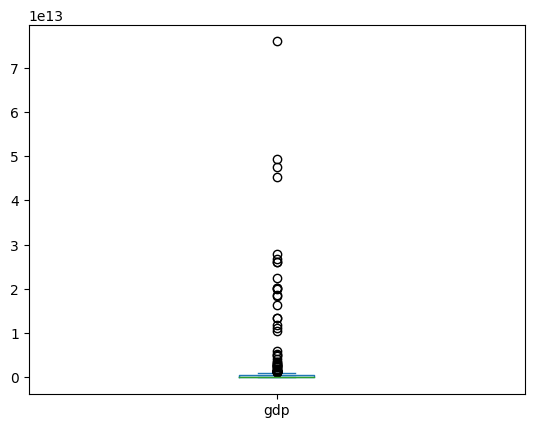

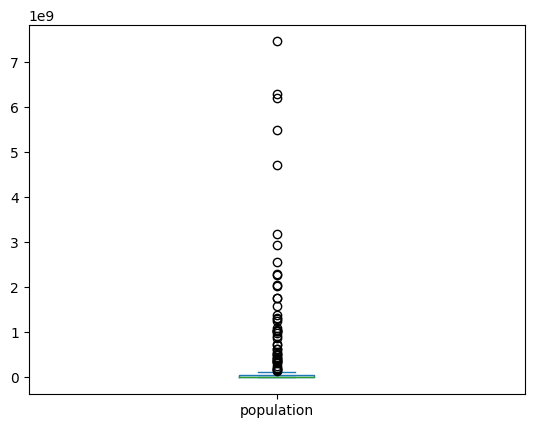

In [79]:
# Make a boxplot of the population data for the year 2016
df_2016.plot('population', kind='box')

# Make a boxplot of the gdp data for the year 2016
df_2016.plot('gdp', kind='box')

Use the Tukey rule to determine what values of the population data are outliers for the year 2016. The Tukey rule finds outliers in one-dimension. The steps are:
1. Find the first quartile (ie .25 quantile)
2. Find the third quartile (ie .75 quantile)
3. Calculate the inter-quartile range (Q3 - Q1)
4. Any value that is greater than Q3 + 1.5 * IQR is an outlier
5. Any value that is less than Qe - 1.5 * IQR is an outlier

In [80]:
# Filter the data for the year 2016 and put the results in the population_2016 variable.
# You only need to keep the Country Name and population columns
population_2016 = df_2016[['Country Name','population']]

# Calculate the first quartile of the population values
# HINT: you can use the pandas quantile method
Q1 = population_2016['population'].quantile(0.25)

# Calculate the third quartile of the population values
Q3 = population_2016['population'].quantile(0.75)

# Calculate the interquartile range Q3 - Q1
IQR = Q3 - Q1

# Calculate the maximum value and minimum values according to the Tukey rule
# max_value is Q3 + 1.5 * IQR while min_value is Q1 - 1.5 * IQR
max_value = Q3 + 1.5 * IQR
min_value = Q1 - 1.5 * IQR

# filter the population_2016 data for population values that are greater than max_value or less than min_value
population_outliers = population_2016[(population_2016['population'] > max_value) | (population_2016['population'] < min_value)]
population_outliers

,Country Name,population
14789,Arab World,4.064527e+08
14802,Bangladesh,1.629516e+08
14811,Brazil,2.076529e+08
14822,China,1.378665e+09
14843,East Asia & Pacific (excluding high income),2.053299e+09
14844,Early-demographic dividend,3.170658e+09
14845,East Asia & Pacific,2.298727e+09
14846,Europe & Central Asia (excluding high income),4.132349e+08
14847,Europe & Central Asia,9.116863e+08
14850,Euro area,3.406174e+08


Many of these aren't countries at all but rather aggregates of various countries. Notice as well that the min_value calculated above was negative. According to the Tukey rule, there are no minimum population outliers in this data set. If you were going to study how population and gdp correlate, you might want to remove these aggregated regions from the data set.

Next, use the Tukey method to do the same analysis for gdp.

In [81]:
# Filter the data for the year 2016 and put the results in the gdp_2016 variable. You only need
# to keep the Country Name and gdp columns
gdp_2016 = df_2016[['Country Name','gdp']]

# Calculate the first quartile of the population values
# HINT: you can use the pandas quantile method
Q1 = gdp_2016['gdp'].quantile(0.25)

# Calculate the third quartile of the population values
Q3 = gdp_2016['gdp'].quantile(0.75)

# TODP: Calculate the interquartile range Q3 - Q1
IQR = Q3 - Q1

# Calculate the maximum value and minimum values according to the Tukey rule
# max_value is Q3 + 1.5 * IQR while min_value is Q1 - 1.5 * IQR
max_value = Q3 + 1.5 * IQR
min_value = Q1 - 1.5 * IQR

# filter the population_2016 data for population values that are greater than max_value or less than min_value
gdp_outliers = gdp_2016[(gdp_2016['gdp'] > max_value) | (gdp_2016['gdp'] < min_value)]
gdp_outliers

,Country Name,gdp
14789,Arab World,2.500164e+12
14795,Australia,1.208039e+12
14811,Brazil,1.793989e+12
14817,Canada,1.535768e+12
14818,Central Europe and the Baltics,1.313067e+12
14822,China,1.119099e+13
14837,Germany,3.477796e+12
14843,East Asia & Pacific (excluding high income),1.350933e+13
14844,Early-demographic dividend,1.043743e+13
14845,East Asia & Pacific,2.251217e+13


Clearly many of these outliers are due to regional data getting aggregated together.

Remove these data points and redo the analysis. There's a list provided below of the 'Country Name' values that are not actually countries.

In [82]:
# remove the rows from the data that have Country Name values in the non_countries list
# Store the filter results back into the df_2016 variable

non_countries = ['World',
 'High income',
 'OECD members',
 'Post-demographic dividend',
 'IDA & IBRD total',
 'Low & middle income',
 'Middle income',
 'IBRD only',
 'East Asia & Pacific',
 'Europe & Central Asia',
 'North America',
 'Upper middle income',
 'Late-demographic dividend',
 'European Union',
 'East Asia & Pacific (excluding high income)',
 'East Asia & Pacific (IDA & IBRD countries)',
 'Euro area',
 'Early-demographic dividend',
 'Lower middle income',
 'Latin America & Caribbean',
 'Latin America & the Caribbean (IDA & IBRD countries)',
 'Latin America & Caribbean (excluding high income)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Middle East & North Africa',
 'Europe & Central Asia (excluding high income)',
 'South Asia (IDA & IBRD)',
 'South Asia',
 'Arab World',
 'IDA total',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Sub-Saharan Africa (excluding high income)',
 'Middle East & North Africa (excluding high income)',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Central Europe and the Baltics',
 'Pre-demographic dividend',
 'IDA only',
 'Least developed countries: UN classification',
 'IDA blend',
 'Fragile and conflict affected situations',
 'Heavily indebted poor countries (HIPC)',
 'Low income',
 'Small states',
 'Other small states',
 'Not classified',
 'Caribbean small states',
 'Pacific island small states']

# remove non countries from the data
df_2016 = df_2016[~df_2016['Country Name'].isin(non_countries)]

In [83]:
# Re-rerun the Tukey code with this filtered data to find population outliers
# Filter the data for the year 2016 and put the results in the population_2016 variable. You only need
# to keep the Country Name and population columns
population_2016 = df_2016[['Country Name','population']]

# Calculate the first quartile of the population values
# HINT: you can use the pandas quantile method
Q1 = population_2016['population'].quantile(0.25)

# Calculate the third quartile of the population values
Q3 = population_2016['population'].quantile(0.75)

# Calculate the interquartile range Q3 - Q1
IQR = Q3 - Q1

# Calculate the maximum value and minimum values according to the Tukey rule
# max_value is Q3 + 1.5 * IQR while min_value is Q1 - 1.5 * IQR
max_value = Q3 + 1.5 * IQR
min_value = Q1 - 1.5 * IQR

# filter the population_2016 data for population values that are greater than max_value or less than min_value
population_outliers = population_2016[(population_2016['population'] > max_value) | (population_2016['population'] < min_value)]
population_outliers

,Country Name,population
14802,Bangladesh,1.629516e+08
14811,Brazil,2.076529e+08
14822,China,1.378665e+09
14825,"Congo, Dem. Rep.",7.873615e+07
14837,Germany,8.234867e+07
14849,"Egypt, Arab Rep.",9.568868e+07
14854,Ethiopia,1.024032e+08
14859,France,6.685977e+07
14863,United Kingdom,6.559556e+07
14888,Indonesia,2.611155e+08


In [84]:
# Filter the data for the year 2016 and put the results in the gdp_2016 variable.
# You only need to keep the Country Name and gdp columns
gdp_2016 = df_2016[['Country Name','gdp']]

# Calculate the first quartile of the population values
# HINT: you can use the pandas quantile method
Q1 = gdp_2016['gdp'].quantile(0.25)

# Calculate the third quartile of the population values
Q3 = gdp_2016['gdp'].quantile(0.75)

# Calculate the interquartile range Q3 - Q1
IQR = Q3 - Q1

# Calculate the maximum value and minimum values according to the Tukey rule
# max_value is Q3 + 1.5 * IQR while min_value is Q1 - 1.5 * IQR
max_value = Q3 + 1.5 * IQR
min_value = Q1 - 1.5 * IQR

# filter the population_2016 data for population values that are greater than max_value or less than min_value
gdp_outliers = gdp_2016[(gdp_2016['gdp'] > max_value) | (gdp_2016['gdp'] < min_value)]
gdp_outliers

,Country Name,gdp
14791,Argentina,5.548609e+11
14795,Australia,1.208039e+12
14796,Austria,3.908000e+11
14799,Belgium,4.675455e+11
14811,Brazil,1.793989e+12
14817,Canada,1.535768e+12
14819,Switzerland,6.687453e+11
14822,China,1.119099e+13
14837,Germany,3.477796e+12
14852,Spain,1.237255e+12


Next, write code to determine which countries are in the population_outliers array and in the gdp_outliers array.

In [85]:
# Find country names that are in both the population_outliers and the gdp_outliers
list(set(population_outliers['Country Name']).intersection(gdp_outliers['Country Name']))

['Indonesia',
 'Turkey',
 'Nigeria',
 'Brazil',
 'United Kingdom',
 'Iran, Islamic Rep.',
 'Thailand',
 'India',
 'Mexico',
 'Russian Federation',
 'Germany',
 'Japan',
 'United States',
 'Italy',
 'China',
 'France']

These countries have both relatively high populations and high GDPs. That might be an indication that although these countries have high values for both gdp and population, they're not true outliers when looking at these values from a two-dimensional perspective.

Now write code to find countries in population_outliers but not in the gdp_outliers.

In [86]:
# Find country names that are in the population outliers list but not the gdp outliers list
# HINT: Python's set() and list() methods should be helpful
list(set(population_outliers['Country Name']) - set(gdp_outliers['Country Name']))

['Pakistan',
 'Vietnam',
 'Ethiopia',
 'Egypt, Arab Rep.',
 'Philippines',
 'Congo, Dem. Rep.',
 'Bangladesh']

These countries are population outliers but not GDP outliers. If looking at outliers from a two-dimensional perspective, there's some indication that these countries might be outliers.

And finally, write code to find countries that are in the gdp_outliers array but not the population_outliers array.

In [87]:
# Find country names that are in the gdp outliers list but not the population outliers list
# HINT: Python's set() and list() methods should be helpful
list(set(gdp_outliers['Country Name']) - set(population_outliers['Country Name']))

['Netherlands',
 'Korea, Rep.',
 'Spain',
 'Switzerland',
 'Saudi Arabia',
 'Austria',
 'Belgium',
 'Canada',
 'Venezuela, RB',
 'Sweden',
 'Poland',
 'Argentina',
 'Australia']

On the other hand, these countries have high GDP but are not population outliers.

Next, look at the data from a two-dimensional perspective. The next code cell plots the GDP vs Population data including the country name of each point.

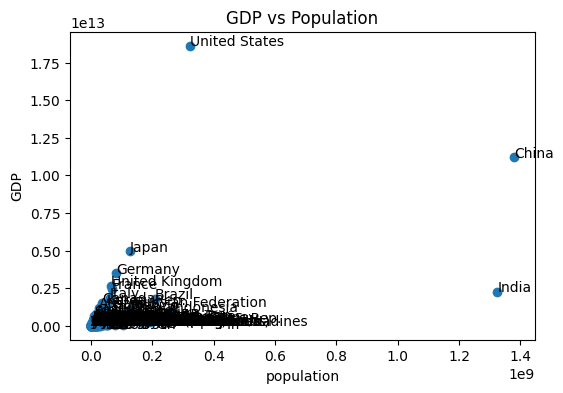

In [88]:
x = list(df_2016['population'])
y = list(df_2016['gdp'])
text = df_2016['Country Name']

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('population')
plt.ylabel('GDP')
for i, txt in enumerate(text):
    ax.annotate(txt, (x[i],y[i]))

The United States, China, and India have such larger values that it's hard to see this data. Let's take those countries out for a moment and look at the data again.

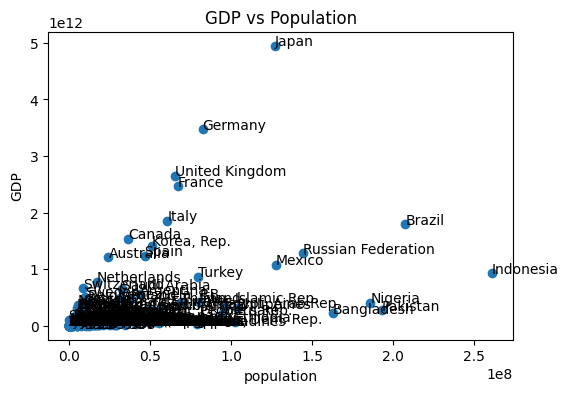

In [90]:
df_no_large = (df_2016['Country Name'] != 'United States') & (df_2016['Country Name'] != 'India') & (df_2016['Country Name'] != 'China')
x = list(df_2016[df_no_large]['population'])
y = list(df_2016[df_no_large]['gdp'])
text = df_2016[df_no_large]['Country Name']

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('population')
plt.ylabel('GDP')
for i, txt in enumerate(text):
    ax.annotate(txt, (x[i],y[i]))

Run the code below to build a simple linear regression model with the population and gdp data for 2016.

[[6.54170378e+12]]


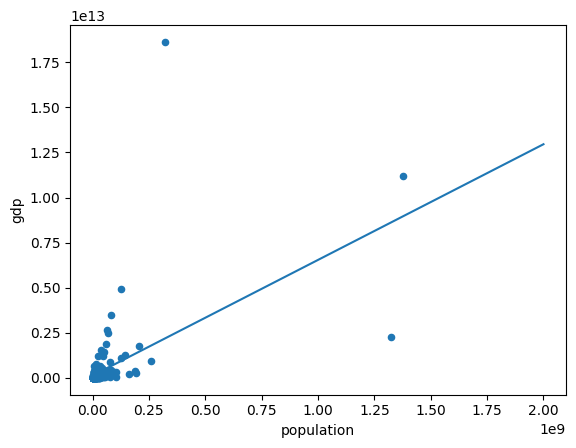

In [91]:
from sklearn.linear_model import LinearRegression

# fit a linear regression model on the population and gdp data
model = LinearRegression()
model.fit(df_2016['population'].values.reshape(-1, 1), df_2016['gdp'].values.reshape(-1, 1))

# plot the data along with predictions from the linear regression model
inputs = np.linspace(1, 2000000000, num=50)
predictions = model.predict(inputs.reshape(-1,1))

df_2016.plot('population', 'gdp', kind='scatter')
plt.plot(inputs, predictions)
print(model.predict([[1000000000]]))

Notice that the code ouputs a GDP value of 6.54e+12 when population equals 1e9. Now run the code below when the United States is taken out of the data set.

[[5.25824554e+12]]


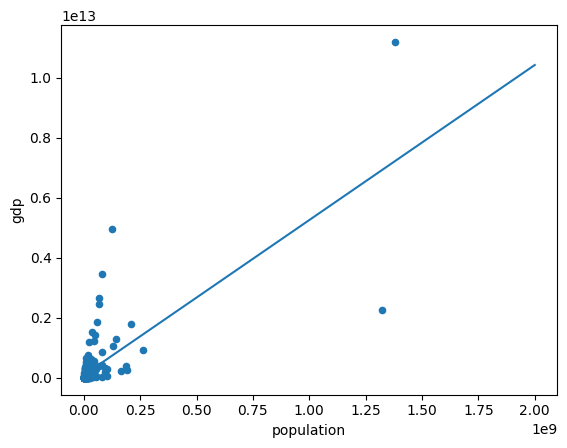

In [92]:
# Remove the United States to see what happens with the linear regression model
df_2016[df_2016['Country Name'] != 'United States'].plot('population', 'gdp', kind='scatter')
# plt.plot(inputs, predictions)
model.fit(df_2016[df_2016['Country Name'] != 'United States']['population'].values.reshape(-1, 1),
          df_2016[df_2016['Country Name'] != 'United States']['gdp'].values.reshape(-1, 1))
inputs = np.linspace(1, 2000000000, num=50)
predictions = model.predict(inputs.reshape(-1,1))
plt.plot(inputs, predictions)
print(model.predict([[1000000000]]))

Notice that the code now ouputs a GDP value of 5.26e+12 when population equals 1e9. In other words, removing the United States shifted the linear regression line down.

Write a function that uses the Tukey rule to eliminate outliers from an array of data.

In [93]:
# Write a function that uses the Tukey rule to detect outliers in a dataframe column and then removes that entire row from the data frame.
# For example, if the United States is detected to be a GDP outlier, then remove the entire row of United States data.
# The function inputs should be a data frame and a column name. The output is a data_frame with the outliers eliminate
def tukey_rule(data_frame, column_name):
    data = data_frame[column_name]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    return data_frame[(data_frame[column_name] < max_value) & (data_frame[column_name] > min_value)]


Now use the function to eliminate population outliers and then gdp outliers from the dataframe. Store results in the df_outlier_removed variable.

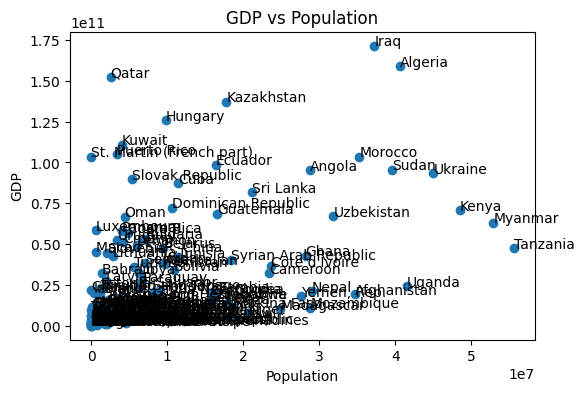

In [94]:
# Use the tukey_rule() function to make a new data frame with gdp and population outliers removed
# Put the results in the df_outlier_removed variable
df_outlier_removed = df_2016.copy()
for column in ['population', 'gdp']:
    df_outlier_removed = tukey_rule(df_outlier_removed, column)

x = list(df_outlier_removed['population'])
y = list(df_outlier_removed['gdp'])
text = df_outlier_removed['Country Name']

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('Population')
plt.ylabel('GDP')
for i, txt in enumerate(text):
    ax.annotate(txt, (x[i],y[i]))

#### 2.2.9 Scaling data
First, write a function that outputs the x_min and x_max values of an array. The inputs are an array of data (like the GDP data). The outputs are the x_min and x_max values

In [96]:
def x_min_max(data):
    # TODO: Complete this function called x_min_max()
    # The input is an array of data as an input
    # The outputs are the minimum and maximum of that array
    minimum = min(data)
    maximum = max(data)
    return minimum, maximum

# this should give the result (36572611.88531479, 18624475000000.0)
x_min_max(df_2016['gdp'])

(36572611.8853148, 18624475000000.0)

Next, write a function that normalizes a data point. The inputs are an x value, a minimum value, and a maximum value. The output is the normalized data point

In [ ]:
def normalize(x, x_min, x_max):
    # The input is a single value
    # The output is the normalized value
    return (x - x_min) / (x_max - x_min)

A good way to keep track of the minimum and maximum values would be to use a class. The Normalizer() class code makes a class that normalizes a data set and stores min and max values.

In [98]:
class Normalizer():
    # The normalizer class receives a dataframe as its only input for initialization
    # For example, the data frame might contain gdp and population data in two separate columns
    # Follow the TODOs in each section

    def __init__(self, dataframe):
        # Assume the dataframe has an unknown number of columns like [['gdp', 'population']]
        # iterate through each column calculating the min and max for each column
        # append the results to the params attribute list

        # For example, take the gdp column and calculate the minimum and maximum
        # Put these results in a list [minimum, maximum]
        # Append the list to the params variable
        # Then take the population column and do the same

        # HINT: You can put your x_min_max() function as part of this class and use it

        self.params = []

        for column in dataframe.columns:
            self.params.append(x_min_max(dataframe[column]))

    def x_min_max(data):
        # TODO: complete the x_min_max method
        # HINT: You can use the same function defined earlier in the exercise
        minimum = min(data)
        maximum = max(data)
        return minimum, maximum

    def normalize_data(self, x):
        # The function receives a data point as an input and then outputs the normalized version
        # For example, if an input data point of [gdp, population] were used. Then the output would
        # be the normalized version of the [gdp, population] data point
        # Put the results in the normalized variable defined below

        # Assume that the columns in the dataframe used to initialize an object are in the same
        # order as this data point x

        # HINT: You cannot use the normalize_data function defined earlier in the exercise.
        # You'll need to iterate through the individual values in the x variable
        # Use the params attribute where the min and max values are stored
        normalized = []
        for i, value in enumerate(x):
            x_max = self.params[i][1]
            x_min = self.params[i][0]
            normalized.append((x[i] - x_min) / (x_max - x_min))
        return normalized

In [99]:
gdp_normalizer = Normalizer(df_2016[['gdp', 'population']])
# should output: [(36572611.88531479, 18624475000000.0), (11097.0, 1378665000.0)]
gdp_normalizer.params

[(36572611.8853148, 18624475000000.0), (11097.0, 1378665000.0)]

### 2.3. Feature Engineering
Create a new feature called gdppercapita in a new column. This feature should be the gdp value divided by the population.

In [100]:
# create a new feature called gdppercapita, which is the gdp value divided by the population value for each country
df_2016['gdppercapita'] = df_2016['gdp'] / df_2016['population']

Write code that creates multiples of a feature. For example, if you take the 'gdp' column and an integer like 3, you want to append a new column with the square of gdp (gdp^2) and another column with the cube of gdp (gdp^3).

create_multiples(b, k) has two inputs. The first input, b, is a floating point number. The second number, k, is an integer. The output is a list of multiples of b. For example create_multiples(3, 4) would return this list: [32,33,34]
 or in other words [9,27,81].

Then the column_name_generator(colname, k) function outputs a list of column names. For example, column_name_generator('gdp', 4) would output a list of strings ['gdp2', 'gdp3', 'gdp4'].

And finally, concatenate_features(df, column, num_columns) uses the two previous functions to create the new columns and then append these new columns to the original data frame.

In [101]:
# The create_multiples function has two inputs. A floating point number and an integer.
# The output is a list of multiples of the input b starting from the square of b and ending at b^k.
def create_multiples(b, k):
    new_features = []

    # TODO: use a for loop to make a list of multiples of b: ie b^2, b^3, b^4, etc... until b^k
    for i in range(2,k+1):
        new_features.append(b ** i)

    return new_features

# The function has two inputs: a string representing a column name and an integer k.
# The 'k' variable is the same as the create_multiples function.
# The output should be a list of column names.
# For example if the inputs are ('gdp', 4) then the output is a list of strings ['gdp2', 'gdp3', gdp4']
def column_name_generator(colname, k):
    col_names = []
    for i in range(2,k+1):
        col_names.append('{}{}'.format(colname, i))
    return col_names


# The function has three inputs. A dataframe, a column name represented by a string, and an integer representing
# the maximum power to create when engineering features.
# If the input is (df_2016, 'gdp', 3), then the output will be the df_2016 dataframe with two new columns
# One new column will be 'gdp2' ie gdp^2, and then other column will be 'gdp3' ie gdp^3.
# HINT: There may be more than one way to do this.
def concatenate_features(df, column, num_columns):
    # Use the pandas apply() method to create the new features. Inside the apply method, you
    # can use a lambda function with the create_mtuliples function
    new_features = df[column].apply(lambda x: create_multiples(x, num_columns))

    # Create a dataframe from the new_features variable
    # Use the column_name_generator() function to create the column names
    # HINT: In the pd.DataFrame() method, you can specify column names inputting a list in the columns option
    # HINT: Using new_features.tolist() might be helpful
    new_features_df = pd.DataFrame(new_features.tolist(), columns = column_name_generator(column, num_columns))

    # concatenate the original date frame in df with the new_features_df dataframe
    # return this concatenated dataframe
    return pd.concat([df, new_features_df], axis=1)

In [102]:
concatenate_features(df_2016, 'gdp', 4)

,Country Name,year,gdp,population,gdppercapita,gdp2,gdp3,gdp4
14784,Aruba,2016,2.584464e+09,104822.0,24655.737223,NaN,NaN,NaN
14785,Afghanistan,2016,1.946902e+10,34656032.0,561.778746,NaN,NaN,NaN
14786,Angola,2016,9.533720e+10,28813463.0,3308.772828,NaN,NaN,NaN
14787,Albania,2016,1.188368e+10,2876101.0,4131.872341,NaN,NaN,NaN
14788,Andorra,2016,2.877312e+09,77281.0,37231.815671,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
212,NaN,NaN,NaN,NaN,NaN,4.509776e+19,3.028534e+29,2.033808e+39
213,NaN,NaN,NaN,NaN,NaN,3.317253e+20,6.041823e+30,1.100417e+41
214,NaN,NaN,NaN,NaN,NaN,8.747557e+22,2.587201e+34,7.651975e+45
215,NaN,NaN,NaN,NaN,NaN,4.391017e+20,9.201269e+30,1.928103e+41


## 3. Load

In [103]:
# read in the projects data set and do basic wrangling
gdp = pd.read_csv('gdp_data.csv', skiprows=4)
gdp.drop(['Unnamed: 62', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)
population = pd.read_csv('population_data.csv', skiprows=4)
population.drop(['Unnamed: 62', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)

# Reshape the data sets so that they are in long format
gdp_melt = gdp.melt(id_vars=['Country Name', 'Country Code'],
                    var_name='year',
                    value_name='gdp')

# Use back fill and forward fill to fill in missing gdp values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby(['Country Name', 'Country Code'])['gdp'].fillna(method='ffill').fillna(method='bfill')

population_melt = population.melt(id_vars=['Country Name', 'Country Code'],
                                  var_name='year',
                                  value_name='population')

# Use back fill and forward fill to fill in missing population values
population_melt['population'] = population_melt.sort_values('year').groupby('Country Name')['population'].fillna(method='ffill').fillna(method='bfill')

# merge the population and gdp data together into one data frame
df_indicator = gdp_melt.merge(population_melt, on=('Country Name', 'Country Code', 'year'))

# filter out values that are not countries
non_countries = ['World',
 'High income',
 'OECD members',
 'Post-demographic dividend',
 'IDA & IBRD total',
 'Low & middle income',
 'Middle income',
 'IBRD only',
 'East Asia & Pacific',
 'Europe & Central Asia',
 'North America',
 'Upper middle income',
 'Late-demographic dividend',
 'European Union',
 'East Asia & Pacific (excluding high income)',
 'East Asia & Pacific (IDA & IBRD countries)',
 'Euro area',
 'Early-demographic dividend',
 'Lower middle income',
 'Latin America & Caribbean',
 'Latin America & the Caribbean (IDA & IBRD countries)',
 'Latin America & Caribbean (excluding high income)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Middle East & North Africa',
 'Europe & Central Asia (excluding high income)',
 'South Asia (IDA & IBRD)',
 'South Asia',
 'Arab World',
 'IDA total',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Sub-Saharan Africa (excluding high income)',
 'Middle East & North Africa (excluding high income)',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Central Europe and the Baltics',
 'Pre-demographic dividend',
 'IDA only',
 'Least developed countries: UN classification',
 'IDA blend',
 'Fragile and conflict affected situations',
 'Heavily indebted poor countries (HIPC)',
 'Low income',
 'Small states',
 'Other small states',
 'Not classified',
 'Caribbean small states',
 'Pacific island small states']

# remove non countries from the data
df_indicator  = df_indicator[~df_indicator['Country Name'].isin(non_countries)]
df_indicator.reset_index(inplace=True, drop=True)

df_indicator.columns = ['countryname', 'countrycode', 'year', 'gdp', 'population']

# output the first few rows of the data frame
df_indicator.head()

,countryname,countrycode,year,gdp,population
0,Aruba,ABW,1960,1.916242e+09,54211.0
1,Afghanistan,AFG,1960,5.377778e+08,8996351.0
2,Angola,AGO,1960,1.857319e+10,5643182.0
3,Albania,ALB,1960,1.857319e+10,1608800.0
4,Andorra,AND,1960,1.857319e+10,13411.0


In [105]:
from pycountry import countries

# read in the projects data set with all columns type string
df_projects = pd.read_csv('projects_data.csv', dtype=str)
df_projects.drop(['Unnamed: 56'], axis=1, inplace=True)
df_projects['countryname'] = df_projects['countryname'].str.split(';').str.get(0)

# set up the libraries and variables
from collections import defaultdict
country_not_found = [] # stores countries not found in the pycountry library
project_country_abbrev_dict = defaultdict(str) # set up an empty dictionary of string values

# iterate through the country names in df_projects.
# Create a dictionary mapping the country name to the alpha_3 ISO code
for country in df_projects['countryname'].drop_duplicates().sort_values():
    try:
        # look up the country name in the pycountry library
        # store the country name as the dictionary key and the ISO-3 code as the value
        project_country_abbrev_dict[country] = countries.lookup(country).alpha_3
    except:
        # If the country name is not in the pycountry library, then print out the country name
        # And store the results in the country_not_found list
        country_not_found.append(country)

# run this code cell to load the dictionary

country_not_found_mapping = {'Co-operative Republic of Guyana': 'GUY',
             'Commonwealth of Australia':'AUS',
             'Democratic Republic of Sao Tome and Prin':'STP',
             'Democratic Republic of the Congo':'COD',
             'Democratic Socialist Republic of Sri Lan':'LKA',
             'East Asia and Pacific':'EAS',
             'Europe and Central Asia': 'ECS',
             'Islamic  Republic of Afghanistan':'AFG',
             'Latin America':'LCN',
              'Caribbean':'LCN',
             'Macedonia':'MKD',
             'Middle East and North Africa':'MEA',
             'Oriental Republic of Uruguay':'URY',
             'Republic of Congo':'COG',
             "Republic of Cote d'Ivoire":'CIV',
             'Republic of Korea':'KOR',
             'Republic of Niger':'NER',
             'Republic of Kosovo':'XKX',
             'Republic of Rwanda':'RWA',
              'Republic of The Gambia':'GMB',
              'Republic of Togo':'TGO',
              'Republic of the Union of Myanmar':'MMR',
              'Republica Bolivariana de Venezuela':'VEN',
              'Sint Maarten':'SXM',
              "Socialist People's Libyan Arab Jamahiriy":'LBY',
              'Socialist Republic of Vietnam':'VNM',
              'Somali Democratic Republic':'SOM',
              'South Asia':'SAS',
              'St. Kitts and Nevis':'KNA',
              'St. Lucia':'LCA',
              'St. Vincent and the Grenadines':'VCT',
              'State of Eritrea':'ERI',
              'The Independent State of Papua New Guine':'PNG',
              'West Bank and Gaza':'PSE',
              'World':'WLD'}

project_country_abbrev_dict.update(country_not_found_mapping)

df_projects['countrycode'] = df_projects['countryname'].apply(lambda x: project_country_abbrev_dict[x])

df_projects['boardapprovaldate'] = pd.to_datetime(df_projects['boardapprovaldate'])

df_projects['year'] = df_projects['boardapprovaldate'].dt.year.astype(str).str.slice(stop=4)

df_projects['totalamt'] = pd.to_numeric(df_projects['totalamt'].str.replace(',',""))

df_projects = df_projects[['id', 'countryname', 'countrycode', 'totalamt', 'year']]

df_projects.head()

,id,countryname,countrycode,totalamt,year
0,P162228,World,WLD,0,2018
1,P163962,Democratic Republic of the Congo,COD,200000000,2018
2,P167672,People's Republic of Bangladesh,BGD,58330000,2018
3,P158768,Islamic Republic of Afghanistan,AFG,20000000,2018
4,P161364,Federal Republic of Nigeria,NGA,100000000,2018


 Merge the two data sets together using country code and year as common keys. When joining the data sets, keep all of the data in the df_projects dataframe even if there is no indicator data for that country code.

In [107]:
# merge the projects and indicator data frames together using countrycode and year as common keys
# Use a left join so that all projects are returned even if the country/year combination does not have indicator data
df_merged = df_projects.merge(df_indicator, how='left', on=['countrycode', 'year'])
df_merged[(df_merged['year'] == '2017') & (df_merged['countryname_y'] == 'Jordan')]

,id,countryname_x,countrycode,totalamt,year,countryname_y,gdp,population
256,P161982,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0
301,P162407,Hashemite Kingdom of Jordan,JOR,147700000,2017,Jordan,4.006831e+10,9702353.0
318,P160103,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0
464,P161905,Hashemite Kingdom of Jordan,JOR,50000000,2017,Jordan,4.006831e+10,9702353.0
495,P163387,Hashemite Kingdom of Jordan,JOR,36100000,2017,Jordan,4.006831e+10,9702353.0
515,P163241,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0


If you look at the first few rows of the merged data set, you'll see NaN's for the indicator data. That is because the indicator data does not contain values for 2018.

Output the df_merged dataframe as a json file

In [108]:
# Output the df_merged data frame as a json file
# HINT: use orient='records' to get one of the more common json formats
# HINT: be sure to specify the name of the json file you want to create as the first input into to_json
df_merged.to_json('countrydata.json', orient='records')

Output the df_merged dataframe as a csv file

In [109]:
# Output the df_merged data frame as a csv file
df_merged.to_csv('countrydata.csv', index=False)

Output the df_merged dataframe as a sqlite database file.

In [110]:
# the database file will be worldbank.db
# note that sqlite3 will create this database file if it does not exist already
conn = sqlite3.connect('worldbank.db')

# output the df_merged dataframe to a SQL table called 'merged'.
# HINT: Use the to_sql() method
# HINT: Use the conn variable for the connection parameter
# HINT: You can use the if_exists parameter like if_exists='replace' to replace a table if it already exists
df_merged.to_sql('merged', con=conn, if_exists='replace', index=False)

18248

In [111]:
pd.read_sql('SELECT * FROM merged WHERE year = "2017" AND countrycode = "BRA"', con=conn).head()

,id,countryname_x,countrycode,totalamt,year,countryname_y,gdp,population
0,P162033,Federative Republic of Brazil,BRA,125000000,2017,Brazil,2.055506e+12,209288278.0
1,P158000,Federative Republic of Brazil,BRA,0,2017,Brazil,2.055506e+12,209288278.0
2,P163868,Federative Republic of Brazil,BRA,250000000,2017,Brazil,2.055506e+12,209288278.0
3,P152285,Federative Republic of Brazil,BRA,0,2017,Brazil,2.055506e+12,209288278.0
4,P147158,Federative Republic of Brazil,BRA,50000000,2017,Brazil,2.055506e+12,209288278.0


Output the data to a SQL database, but this time, put the df_indicator data in one table and the df_projects data in another table. Call the df_indicator table 'indicator' and the df_projects table 'projects'.

In [112]:
# the database file will be worldbank.db
conn = sqlite3.connect('worldbank.db')

# put the df_indicator data in one table and the df_projects data in another table.
df_indicator.to_sql('indicator', con = conn, if_exists='replace', index=False)
df_projects.to_sql('projects', con = conn, if_exists='replace', index=False)

18248

In [113]:
pd.read_sql('SELECT * FROM projects LEFT JOIN indicator ON \
projects.countrycode = indicator.countrycode AND \
projects.year = indicator.year WHERE \
projects.year = "2017" AND projects.countrycode = "BRA"', con = conn).head()

,id,countryname,countrycode,totalamt,year,countryname,countrycode,year,gdp,population
0,P162033,Federative Republic of Brazil,BRA,125000000,2017,Brazil,BRA,2017,2.055506e+12,209288278.0
1,P158000,Federative Republic of Brazil,BRA,0,2017,Brazil,BRA,2017,2.055506e+12,209288278.0
2,P163868,Federative Republic of Brazil,BRA,250000000,2017,Brazil,BRA,2017,2.055506e+12,209288278.0
3,P152285,Federative Republic of Brazil,BRA,0,2017,Brazil,BRA,2017,2.055506e+12,209288278.0
4,P147158,Federative Republic of Brazil,BRA,50000000,2017,Brazil,BRA,2017,2.055506e+12,209288278.0


In [114]:
# commit any changes to the database and close the database
conn.commit()
conn.close()

SQLite, as its name would suggest, is somewhat limited in its functionality. For example, the Alter Table command only allows you to change a table name or to add a new column to a table. You can't, for example, add a primary key to a table once the table is already created.

If you want more control over a sqlite3 database, it's better to use the sqlite3 library directly. Here is an example of how to use the sqlite3 library to create a table in the database, insert a value, and then run a SQL query on the database. Run the code cells below to see the example.

In [115]:
# connect to the data base
conn = sqlite3.connect('worldbank.db')

# get a cursor
cur = conn.cursor()

# drop the test table in case it already exists
cur.execute("DROP TABLE IF EXISTS test")

# create the test table including project_id as a primary key
cur.execute("CREATE TABLE test (project_id TEXT PRIMARY KEY, countryname TEXT, countrycode TEXT, totalamt REAL, year INTEGER);")

# insert a value into the test table
cur.execute("INSERT INTO test (project_id, countryname, countrycode, totalamt, year) VALUES ('a', 'Brazil', 'BRA', '100,000', 1970);")

# commit changes made to the database
conn.commit()

# select all from the test table
cur.execute("SELECT * FROM test")
cur.fetchall()

[('a', 'Brazil', 'BRA', '100,000', 1970)]

In [116]:
# commit any changes and close the data base
conn.close()

Exercise: Use the sqlite3 library to connect to the worldbank.db database. Then:
- Create a table, called projects, for the projects data where the primary key is the id of each project.
- Create another table, called gdp, that contains the gdp data.
- And create another table, called population, that contains the population data.

Here is the schema for each table.
**projects**
- project_id text
- countryname text
- countrycode text
- totalamt real
- year integer
project_id is the primary key

**gdp**
- countryname text
- countrycode text
- year integer
- gdp real
(countrycode, year) is the primary key

**population**
- countryname text
- countrycode text
- year integer
- population integer
(countrycode, year) is the primary key

After setting up the tables, write code that inserts the data into each table.

In [117]:
# connect to the data base
conn = sqlite3.connect('worldbank.db')

# get a cursor
cur = conn.cursor()

# drop tables created previously to start fresh
cur.execute("DROP TABLE IF EXISTS test")
cur.execute("DROP TABLE IF EXISTS indicator")
cur.execute("DROP TABLE IF EXISTS projects")
cur.execute("DROP TABLE IF EXISTS gdp")
cur.execute("DROP TABLE IF EXISTS population")

# create the projects table including project_id as a primary key
cur.execute("CREATE TABLE projects (project_id TEXT PRIMARY KEY, countryname TEXT, countrycode TEXT, totalamt REAL, year INTEGER);")

# create the gdp table including (countrycode, year) as primary key
# HINT: To create a primary key on multiple columns, you can do this:
# CREATE TABLE tablename (columna datatype, columnb datatype, columnc dataype, PRIMARY KEY (columna, columnb));
cur.execute("CREATE TABLE gdp (countryname TEXT, countrycode TEXT, year INTEGER, gdp REAL, PRIMARY KEY (countrycode, year));")

# create the population table including (countrycode, year) as primary key
cur.execute("CREATE TABLE population (countryname TEXT, countrycode TEXT, year INTEGER, population REAL, PRIMARY KEY (countrycode, year));")

# commit changes to the database. Do this whenever modifying a database
conn.commit()

In [118]:
# insert project values into the projects table
# HINT: Use a for loop with the pandas iterrows() method
# HINT: The iterrows() method returns two values: an index for each row and a tuple of values
# HINT: Some of the values for totalamt and year are NaN. Because you've defined
# year and totalamt as numbers, you cannot insert NaN as a value into those columns.
# When totaamt or year equal NaN, you'll need to change the value to something numeric
# like, for example, zero

for index, values in df_projects.iterrows():
    project_id, countryname, countrycode, totalamt, year = values

    if totalamt == 'nan':
        totalamt = 0
    if year == 'nan':
        year = 0

    sql_string = 'INSERT INTO projects (project_id, countryname, countrycode, totalamt, year) VALUES ("{}", "{}", "{}", {}, {});'.format(project_id, countryname, countrycode, totalamt, year)
    cur.execute(sql_string)

conn.commit()

In [119]:
# insert gdp values into the gdp table
for index, values in df_indicator[['countryname', 'countrycode', 'year', 'gdp']].iterrows():
    countryname, countrycode, year, gdp = values

    sql_string = 'INSERT INTO gdp (countryname, countrycode, year, gdp) VALUES ("{}", "{}", {}, {});'.format(countryname, countrycode, year, gdp)
    cur.execute(sql_string)

conn.commit()

In [120]:
# insert population values into the population table
for index, values in df_indicator[['countryname', 'countrycode', 'year', 'population']].iterrows():
    countryname, countrycode, year, population = values

    sql_string = 'INSERT INTO population (countryname, countrycode, year, population) VALUES ("{}", "{}", {}, {});'.format(countryname, countrycode, year, population)
    cur.execute(sql_string)

conn.commit()

In [121]:
# run this command to see if your tables were loaded as expected
sqlquery = "SELECT * FROM projects JOIN gdp JOIN population ON projects.year = gdp.year AND projects.countrycode = gdp.countrycode AND projects.countrycode = population.countrycode AND projects.year=population.year;"
result = pd.read_sql(sqlquery, con=conn)
result.shape

(15322, 13)

In [122]:
# commit any changes and close the database
conn.commit()
conn.close()